# Methods for Data Science Coursework 2

## Introdution

In this coursework, we are going to run two main task:
$$$$ - a supervised learning task (classification task using neural networks) on a collection of images
$$$$ - a unsupervised learning task (clustering, dimensionality reduction and graph-based analysis) on a social network dataset

We will accomplish these tasks using different methods and comparing the obtained results. 

First, we print the GPU we are going to work with most of the time. Then, we import the python tools we are going to need to work with the data.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar 26 09:39:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import tensorflow as tf
from scipy.sparse import linalg


## 1. Neural networks

In task 1, we are going to implement supervised classification methods. We will study two different neural network: Multi-layer perceptron and Convolutional neural network. 
The aim of both methods is to classify the dataset of images into 10 classes: airplanes, birds, cars, ships, etc. We have 50,000 training and 10,000 validation images of dimension (32,32,3) in python corresponding to images of 32x32 pixels, each with 3 colour chanels. 
The CIFAR-10 dataset is well balanced, it has 5,000 images of each class in the training set and 1,000 images of each class in the validation set.


Next, lets import the files in order to have a first look at the data and its configuration. 

In [4]:
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    # convert labels to categorical samples 
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

In [5]:
(x_train, y_train), (x_val, y_val) = load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
y_train.shape

(50000, 10)

We can check that the frequency of each class are indeed equal.

In [8]:
y_train_prob = np.mean(y_train,axis=0)
y_train_prob

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)

In [9]:
y_val_prob = np.mean(y_val,axis=0)
y_val_prob

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)

In the first part of task 1, we will work with vectors of shape 3072 containing the colour chanels of each pixel per image. Let's reshape our data.

In [10]:
def reshape_to_vec(x_train,x_val):
    x_train2=x_train.reshape((x_train.shape[0],3072))
    x_val2=x_val.reshape((x_val.shape[0],3072))
    return x_train2,x_val2

In [11]:
x_train,x_val=reshape_to_vec(x_train,x_val)

Let's standardise the training and validation data according to the training data's mean and standard deviation. This will allow us to compare rsults and get better results.

In [12]:
def standardise(X):
    N,D=X.shape
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std= (X - mu) / sigma
    return X_std,mu,sigma

In [13]:
x_train,mu,sigma=standardise(x_train)
x_val=(x_val-mu)/sigma

The data is finally ready to be used to build all nerual network models: multi-layer perceptron and convolutional neural networks. All models will be trained using the training data and tested on the test data. To compare the models we will compare their respective loss function and their performance (measured by their accuracy). 

### 1.1 Multi-layer perception

#### 1.1.1

Now we should implement an MLP model in numpy. Our model will have five hidden layers with 400 neurons each, and using the standardised tanh activation function. The final output layer will be a single neuron with no activation function to predict the target variable $y$.

The building block of the model is the dense (or fully-connected) layer. The following function should implement the affine transformation of this layer, given kernel and bias parameters and the input to the layer. It should return the layer pre-activations (no activation function).

Setting the parameters of our MLP:

From input layer to first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{3072\times 400}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{400}$

From hidden layer to hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{400\times 400}$, $k=1,\cdots,4$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{400}$, $k=1,\cdots,4$

From last hidden layer to output layer:
* Kernel $\boldsymbol{W}^{(5)} \in\mathbb{R}^{400\times 10}$
* Bias $\boldsymbol{b}^{(5)} \in\mathbb{R}^{10}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. The bias parameters will be initialised to zeros. This strategy comes from the coding task. 

In [14]:
def initiate_W_b():
    # Initiate the parameters
    #parameters from input to layer
    var = []
    W=[]
    b=[]

    var.append(2. / (3072 + 400))
    W.append(np.random.randn(3072, 400) * np.sqrt(var[0]))
    b.append(np.zeros(400))
    
    #parameters from layer to layer
    for i in range(4):
        var.append(2. / (400 + 400))
        W.append(np.random.randn(400, 400) * np.sqrt(var[i]))
        b.append(np.zeros(400))
    
    #parameters from layer to output
    var.append(2. / (10 + 400))
    W.append(np.random.randn(400,10) * np.sqrt(var[5]))
    b.append(np.zeros(10))
    return W,b

In [15]:
W,b=initiate_W_b()

Using this parameters in our situation we will have:
Initialisation:
$$
\boldsymbol h^{(0)} := \boldsymbol x
$$
Iterations:
$$
\boldsymbol h^{(k)} := \sigma \left(\boldsymbol W^{(k-1)} h^{(k-1)} +  b^{(k)} \right), \quad k=1, \cdots, 5
$$
with $\sigma(\boldsymbol x) = tanh(\boldsymbol x)$. 
Resulting model: 
$$
\hat{y} := \sigma_{out} \left(\boldsymbol W^{(out)} h^{(out)} +  b^{(out)} \right) 
$$
with $\sigma_{out}(\boldsymbol a _i) = \mathrm{softmax}(\boldsymbol a _i) = \frac{\mathrm{exp}(\boldsymbol a _i)}{\sum_{j=1}^{n} \mathrm{exp(\boldsymbol a _j)}}$ being the softmax function.

In [16]:
def dense(x, W, b):
    a=np.zeros(x.shape)
    a = b.T + x@W # pre-activation step
    return a

In [17]:
def softmax(a):
    y_pred=np.exp(a)
    y_pred=np.reciprocal(np.sum(np.exp(a),axis=1))*y_pred.T
    return y_pred.T

In [18]:
def mlp(x,W,b):
    h=x  #first layer
    h_all=[h] #store the hˆ(k)
    a_all=[] #store the aˆ(k)
    for i in range(5):  #interations for 5 layers
        a = dense(h, W[i], b[i]) #pre-activation
        h = np.tanh(a) #post-activation
        h_all.append(h)
        a_all.append(a)
    a = dense(h, W[5], b[5]) #from last layer to output
    a_all.append(a)
    y_pred = softmax(a) #post-activation for output with softmax function
    return y_pred,h_all,a_all

The loss function that we wish to minimise is the cross-entropy loss function, computed for $x_i,y_i \in \mathcal{D}_{train}$ where $\mathcal{D}_{train}$ is a randomly sampled minibatch of 128 training data points:

$$
\mathcal{L}(\theta,\mathcal{D}_{train}) := \frac{1}{|\mathcal{D}_{m}|} \underset{x_i,y_i \in \mathcal{D}_{m}}{\sum} l_{CE}(y_{i},f_{\theta}(x_i))
$$
where $f_{\theta}(x_i)$ is the function representing our neural network model and $l_{CE}(y_{i},f_{\theta}(x_i))$ is the cross-entropy loss function as follow:

$$
l_{CE}(y_i,f_{\theta}(x_i)) = - \underset{j=1}{\sum}^{n} y_{i}^{(j)}\mathrm{log}(f_{\theta}(x_i^{(j)}))
$$

where $n$ is the number of classes, here n=10 and $f_{\theta}(x_i^{(j)}) = \hat{y}_i^{(j)}$ is the predicted probability of the j-th label of the observation $x_i$ calculated with our neural network model.


In [19]:
# cross-entropy
def cross_entropy_loss(y, y_pred):
    L=0
    for i in range(y.shape[0]):
        l_CE=0
        for j in range(y.shape[1]):
            l_CE += -y[i,j]*math.log(y_pred[i,j]) # formula of cross-entropy loss function
        L += l_CE
    L = L / y.shape[0]
    return L

In [20]:
def cross_entropy(y,y_pred):
    l_CE=0
    for j in range(10):
        l_CE += -y[j]*math.log(y_pred[j]) # formula of cross-entropy loss function
    return l_CE

Stochastic gradient descent samples a batch of $K$ input and output samples, and makes a parameter update by  computing the gradient and updating the parameters $\theta$ as follow:

$$
\theta_{t+1}=\theta_{t} - \eta \nabla_{\theta}\mathcal{L}(\theta_{t};\mathcal{D}_{m}) 
$$
where $\theta_{t}$ are the values of the parameters at the $t$-th iteration of the algorithm, that we will specify later. The following function should compute this gradient for a given batch of data of size 128, and current parameter values. 

To compute the gradient for the parameter $\boldsymbol W^{(k)}$ and $\boldsymbol b^{(k)}$, we need to compute:
$$(\nabla_{\theta}\mathcal{L})_{j} = \frac{\partial \mathcal{L}}{\partial \theta_{j}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} . \frac{\partial \hat{y}}{\partial \theta_{j}}$$
for all $\boldsymbol W ^{(k)}$ and $b^{(k)}$, for k = 0,1,...,5
$$
\frac{\partial L_i}{\partial W_{pq}^{(k)}} = \frac{\partial L_i}{\partial a_{p}^{(k+1)}} \frac{\partial a_{p}^{(k+1)}}{\partial W_{pq}^{(k)}} = \delta_{p}^{(k+1)} h_{q}^{(k)} \quad \quad \frac{\partial L_i}{\partial b_{p}^{(k)}} = \frac{\partial L_i}{\partial a_{p}^{(k+1)}} \frac{\partial a_{p}^{(k+1)}}{\partial b_{p}^{(k)}} = \delta_{p}^{(k+1)}
$$
with $\delta_{p}^{(k)} = \sigma^{'}(a_{p}^{(k)}) \sum _{j=1}^{n_{k+!}} W_{jp}^{(k)} \delta_{p}^{(k+1)}$ and with $\sigma^{'}(x) = \mathrm{tanh}^{'}(x) = 1-\mathrm{tanh}^2(x) $

Giving in matrix-vecotr form:
$$\frac{\partial L_i}{\partial W^{(k)}} = \delta^{(k+1)T} h^{(k)} \quad \quad \frac{\partial L_i}{\partial b^{(k)}} = \delta^{(k+1)}$$
with $\delta^{(k)} = \mathrm{diag}([\sigma^{'}(a_{p}^{(k)})]_{p=1}^{n_{k}}) W^{(k)T} \delta^{(k+1)}$.

To apply these formulas in the next grad function, we need:
$$\delta_{j}^{(5)} = \frac{\partial L}{\partial a_{j}^{(5)}} = \frac{1}{|\mathcal{D}_{m}|}\underset{x_i,y_i \in \mathcal{D}_{m}}{\sum} \frac{\partial L_i}{\partial a_{j}^{(5)}} \\
= \frac{1}{|\mathcal{D}_{m}|} \underset{x_i,y_i \in \mathcal{D}_{m}}{\sum} \frac{\partial}{\partial a_{j}^{(5)}} l_{CE}(y_{i},\hat{y}_{i}) \\
= \frac{1}{|\mathcal{D}_{m}|} \underset{x_i,y_i \in \mathcal{D}_{m}}{\sum} \frac{\partial}{\partial a_{j}^{(5)}} l_{CE}(y_{i},\hat{y}_{i})\\
\delta_{j}^{(5)} =  \frac{1}{|\mathcal{D}_{m}|} \underset{x_i,y_i \in \mathcal{D}_{m}}{\sum} - \frac{y_{i}^{(j)}}{\hat{y}_{i}} \frac{\partial \hat{y}_{i} }{ \partial a_{j}^{(5)}}$$

The derivative of $\sigma'(\boldsymbol x) = \mathrm{tanh} (\boldsymbol x)$ is:
$$
\frac{\partial \sigma(\boldsymbol x)}{\partial \boldsymbol x_j} = \frac{\partial}{\partial \boldsymbol x_j} \mathrm{tanh}(\boldsymbol x) = 1- \mathrm{tanh}^{2}(x_j) 
$$

In [21]:
def tanh_der(x):
    return np.ones(x.shape)-np.square(np.tanh(x))

The derivative of the last activation function $\sigma^{(out)}(\boldsymbol a^{(5)}) = \mathrm{softmax}(\boldsymbol a^{(5)}) = \hat{y}_i$ is as follow :
$$
\frac{\partial \hat{y}_i}{\partial a^{(5)}_j} = \begin{cases} \hat{y}_i(1 - \hat{y}_i) \quad & \mathrm{if} \quad i=j \\
- \hat{y}_{j} \hat{y}_{i} \quad & \mathrm{if} \quad i \neq j \\
\end{cases}
$$


Now when doing the backpropagation , we compute the gradient for all parameters $W^{(k)},b^{(k)}$ , and we need an initial parameter $\delta^{(5)}$, defined as:
$$
\delta_{j}^{(5)} =  \frac{1}{|\mathcal{D}_{m}|} \underset{y \in \mathcal{D}_{m}}{\sum} \underset{i}{\sum} - \frac{y_{i}}{\hat{y}_{i}} \frac{\partial \hat{y}_{i} }{ \partial a_{j}^{(5)}}\\
\delta_{j}^{(5)} = \frac{1}{|\mathcal{D}_{m}|} \underset{y \in \mathcal{D}_{m}}{\sum} \underset{i}{\sum} \begin{cases} -  \frac{y_{i}}{\hat{y}_{i}} \hat{y}_i(1 - \hat{y}_i) \quad & \mathrm{if} \quad i=j \\
- \frac{y_{i}}{\hat{y}_{i}} (-\hat{y}_{j} \hat{y}_{i}) \quad & \mathrm{if} \quad i \neq j \\
\end{cases}\\
\delta_{j}^{(5)} = \frac{1}{|\mathcal{D}_{m}|} \underset{y \in \mathcal{D}_{m}}{\sum} \underset{i}{\sum} \begin{cases} -  y_{i} (1 - \hat{y}_i) \quad & \mathrm{if} \quad i=j \\
 y_{i} \hat{y}_{j} \quad & \mathrm{if} \quad i \neq j \\
\end{cases}\\
\delta_{j}^{(5)} =  - \frac{1}{|\mathcal{D}_{m}|} \underset{y \in \mathcal{D}_{m}}{\sum} \left[  y_{i} (1 - \hat{y}_i) - \underset{i \neq j}{\sum}  y_{i} \hat{y}_{j} \right]\\
\delta_{j}^{(5)} =  - \frac{1}{|\mathcal{D}_{m}|} \underset{y \in \mathcal{D}_{m}}{\sum} \left[  y_{i} -\underset{i}{\sum}  y_{i} \hat{y}_{j} \right]$$
Now, we know that the components of $y_i$ are all zero except one entry equal to 1 which corresponds to the class it belongs to, so $ \underset{y_i  \in \mathcal{D}_{m}}{\sum} y_{j} \hat{y}_{j} =  \hat{y}_{j}$.

Therefore, 
$$
\delta_{j}^{(5)} =  - \frac{1}{|\mathcal{D}_{m}|} \underset{y \in \mathcal{D}_{m}}{\sum} \left[  y_{j} - \hat{y}_{j} \right]\\
\delta_{j}^{(5)} =  \frac{1}{|\mathcal{D}_{m}|} \underset{y \in \mathcal{D}_{m}}{\sum} \left[  y_{j} - \hat{y}_{j} \right]$$
which is simply the average error between the predicted  $\hat{y}_{j} $ and the true values $y_j$. 

We can now implement the gradient function for all the parameters using the backpropagation formulas:
$$\frac{\partial L_i}{\partial W^{(k)}} = \delta^{(k+1)T} h^{(k)} \quad \quad \frac{\partial L_i}{\partial b^{(k)}} = \delta^{(k+1)}$$

which is iniliased with $\delta^{(5)}$ simply being the error. 

In [22]:
def grad(y_pred,h_all,a_all,y):
    
    W_grad= [None] * 6
    b_grad=[None] * 6

    delta_k=y_pred-y # initialise backdrop
    b_grad[5] = np.mean(delta_k,axis=0)
    W_grad[5] = delta_k.T@h_all[5]/128
    for k in range(5):
        k=4-k
        delta_k= delta_k@W[k+1].T # apply formula 
        delta_k= tanh_der(a_all[k])*delta_k # with dimensions: 128x400 * 128x400
        b_grad[k] = np.mean(delta_k,axis=0)/128
        W_grad[k] = delta_k.T@h_all[k]/128
    return b_grad, W_grad

Our version of the Stochastic Grandient Descent has two hyparameters:
- the learning rate (here $\eta= 0.01$) which acts as a stoping criterion
- the number of epoches (here 40) which defines the number times that the model will work through the entire training data.
We will make a for-loop over the number of epochs and within this for-loop another nested for-loop iterates over each batch of samples of 128 points.

Steps of MLP with SGD:

. initiate parameters

. for loop over the number of epochs:

. for loop over x_batch: 

-     compute MLP with forward propagation with the tanh activation function for the first 4 hidden layers and softmax function for the last layer
-     compute gradient with backpropagation: $\frac{\partial L_i}{\partial W^{(k)}} = \delta^{(k+1)T} h^{(k)} \quad \quad \frac{\partial L_i}{\partial b^{(k)}} = \delta^{(k+1)}$
-     update parameters with learning rate: $
\theta_{t+1}=\theta_{t} - \eta \nabla_{\theta}\mathcal{L}(\theta_{t};\mathcal{D}_{m}) 
$
-     calculate training and validation cross-entropy loss function and store it 
-     calculate training and validation accuracy and store it 

Before proceeding to the Stochastic Gradient Descent, we will split our data into batches of size 128. By leaving out the last batch of size 80, we get 390 batches. We first shuffle the data, with the function bellow, to get random batches at every epoch. 

In [23]:
def shuffle(X,y):
    import random
    seed = 10
    N,D=X.shape
    np.random.seed(seed) #the random seed
    Xy_shuf=np.random.permutation(np.append(X,y,axis=1))
    X_shuf=Xy_shuf[:,:D]
    y_shuf=Xy_shuf[:,D:]
    return X_shuf,y_shuf

In [24]:
#split-batch
def split_batch(x,y):
    x,y=shuffle(x,y) #shuffle data
    #we will append folds and validation sets in list of length 5
    x_train_batch=[]
    y_train_batch=[]
    for i in range(math.floor(x.shape[0]/128)+1):
        #split in 390 batchs of size and 1 batch with the remaining points 
        x_train_batch.append(x[128*i:128*(i+1),:])
        y_train_batch.append(y[128*i:128*(i+1),:])
    return x_train_batch,y_train_batch

In [25]:
x_train_batch,y_train_batch=split_batch(x_train,y_train)

We have seen how to do all steps, except the computation of the accuracy. 

To compute the accuracy, we first have to transform the predicted vectors $\hat{y}_i$. Indeed, the vectors $\hat{y}_i$ are the predicted probability distribution across the 10 class, for each observation i. 

To convert them into vectors with binary entries corresponding to the predicted class, we set all the entries to be 0 except the entry corresponding to highest value of probability which we set equal to 1, like the function bellow. 

In [26]:
def prob_to_10(y_pred):
    y_pred_10 = np.zeros(y_pred.shape)
    highest_prob = np.argmax(y_pred,axis=1)
    for i in range(y_pred.shape[0]):
        y_pred_10[i,highest_prob[i]]=1
    return y_pred_10

Now that we have our predicted classes, we can compute the accuracy of the model using the formula:
$$
accuracy = \frac{T_c}{N}
$$
where $T_c$ is the number of true classifications (ie. when $\hat{y}_i = y_i$), and n is the number of predicted classifications (here 50,000 for training images and 1,000 for validation images).

Doing this at each epoch, we get 40 values of accuracy. 

In [27]:
def accuracy_comp(y_pred_10,y):
    n,d = y.shape
    accuracy=0
    for i in range(d):
        accuracy += sum(1 for k in range(n) if (y[k,i]==1)&(y_pred_10[k,i]==1))
    return accuracy/n

We can finally implement the multi-layer perceptron with the SGD optimisation method and cross-entropy loss function, as required:

In [28]:
def sgd(x_train,y_train,x_val,y_val,epochs=40,learning_rate=0.01):
    
    W,b = initiate_W_b() #initialize parameters for each batch
    
    losses_train=[]
    losses_val = []
    accuracies_train=[]
    accuracies_val=[]
    nb_batch=math.floor(x_train.shape[0]/128)
    iterations=epochs*nb_batch
    
    for j in range(epochs):
        x_train_batch,y_train_batch=split_batch(x_train,y_train)
        #loss=0
        #accuracy=0
        for k in range(nb_batch):
            #forward propagation
            y_pred,h_all,a_all=mlp(x_train_batch[k],W,b)

            #backpropagation: calculate gradient for all parameter W and b
            b_grad, W_grad = grad(y_pred,h_all,a_all,y_train_batch[k]) 
            for s in range(6):
                W[s] += -learning_rate * W_grad[s].T
                b[s] += -learning_rate * b_grad[s].T
            #loss = cross_entropy_loss(y_train_batch[k], y_pred)

        #for x_train
        y_pred_train,h_all,a_all=mlp(x_train,W,b)
        loss_train = cross_entropy_loss(y_train, y_pred_train)
        #from predicted probability to predicted class
        y_pred_10_train = prob_to_10(y_pred_train)
        accuracy_train = accuracy_comp(y_pred_10_train,y_train)

        losses_train.append(loss_train)
        accuracies_train.append(accuracy_train)

        #for x_val
        y_pred_val,h_all,a_all=mlp(x_val,W,b)
        loss_val = cross_entropy_loss(y_val, y_pred_val)
        #from predicted probability to predicted class
        y_pred_10_val = prob_to_10(y_pred_val)
        accuracy_val = accuracy_comp(y_pred_10_val,y_val)

        losses_val.append(loss_val)
        accuracies_val.append(accuracy_val)
    return W,b,losses_train,accuracies_train,losses_val,accuracies_val

When training the model, we compute the loss function and the accuracy for both training and validation data sets with the obtaines model with parameters W and b at each epoch.

In [29]:
import time 
from time import process_time
# Start the stopwatch / counter 
t_start_mlp = process_time() 
W,b,losses_train,accuracies_train,losses_val,accuracies_val = sgd(x_train,y_train,x_val,y_val,epochs=40,learning_rate=0.01)
# Stop the stopwatch / counter
t_stop_mlp = process_time()

t_mlp = t_stop_mlp - t_start_mlp


In all the following plots of task 1, the blue line describes the performance of the model for the training data and the orange line describes the performance of the model for the validation data. 

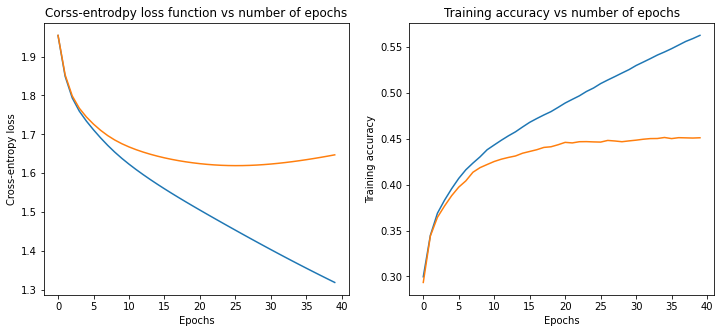

In [30]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.title("Corss-entrodpy loss function vs number of epochs")

fig.add_subplot(122)
plt.plot(accuracies_train)
plt.plot(accuracies_val)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy vs number of epochs")

plt.show()

For the loss function plot, we recall the formula of the cross-entropy loss function. It implies that as the predicted probability approaches 1, the log of the predicted probability approaches 0. 
$$
\mathcal{L}(\theta,\mathcal{D}_{train}) := \frac{-1}{|\mathcal{D}_{m}|} \underset{x_i,y_i \in \mathcal{D}_{m}}{\sum} \underset{j=1}{\sum}^{n} y_{i}^{(j)}\mathrm{log}(\hat{y}_i^{(j)}))$$

Therefore, the cross-entropy loss function especially penalizes the predictions that have a high predicted probability and are wrong. 

To analyse the performance of a model, we prioritise the orange curve of the loss function:
- before the minimal point, the model is undefitting
- at the minimal point, the model is optimal
- after the minimal point, the model is overfitting.



From the graph, there is clearly overfitting happening as the blue curve is converging to 1 for 40 epochs and probabily to 0 for more epochs, whereas the orange curve starts to increase after 10 epochs. This means that when the model is training for more epochs, the model is overfitted as validation results get worse. Clearly we give more importance to the orange curve of validation performance since we are interested in using the model with unseen images. 

For the accuracy plot, overfitting is happening again. We can see that the accuracy doesn't stop increasing with the number of epochs for the training data whereas, after 10 epochs, the orange curve starts decreasing.

**Interpretation**

The plots of the loss function and accuracy show a considerable difference of results between training and validation sets. 
From the graphs, we can see that overfitting is clearly happening. The model does actually start to learn at the beginning (for the approximately 10 first epochs) but after that it starts to diverge. The blue curve of training data and orange curve of validation data diverge in both plots of loss function and accuracy. We can say that the over-fitting, accures rapidly but it is not drastic (the loss function for validation data starts increasing slightly and similarly the accuracy curve for validation data starts decreasing slightly). 
For 40 epochs and learning rate $\eta = 0.01$, the optimal model is atteined after 10 epochs (lowest loss function and highest accuracy). 

We can try to explain the slight overfitting happening after the 10th epoch, by several reasons:
- the size of batch is too small (only 128 data points): he model will make more frequent updates to the parameters which can lead to overfitting
- the model depends on too many parameters: 

$\boldsymbol{W}^{(0)} \in\mathbb{R}^{3072\times 400}$, $\boldsymbol{b}^{(0)} \in\mathbb{R}^{400}$, $\boldsymbol{W}^{(k)} \in\mathbb{R}^{400\times 400}$, $\boldsymbol{b}^{(k)} \in\mathbb{R}^{400}$, $k=1,\cdots,4$, $\boldsymbol{W}^{(5)} \in\mathbb{R}^{400\times 10}$ and $\boldsymbol{b}^{(5)} \in\mathbb{R}^{10}$

In [31]:
400*3072+400+4*400*400+400+400*10+10

1873610

Regrouping all these parameters, we have 1,873,610 parameters in total, which is a lot.

The size of batch and the number of parameters are going to remain fixed because that is what the task is asking. However, in the next questions, we will change the value of the hyperparameter $\eta$ to try to avoid or at least reduce overfitting.


#### 1.1.2

We are now going to have a look at the performance of the model according to the hyperparameter of the learning rate $\eta$. 

Indeed, when using an SGD optimiser, the learning rate has a hight influence on the values of the parameter at each epoch: the updating step controls how much to change the parameters in response to the estimated error. 

We will run the same MLP with 40 epochs but with a smaller learning rate $\eta = 0.0001$ instead of 0.01. 

In [32]:
W1,b1,losses_train1,accuracies_train1,losses_val1,accuracies_val1 = sgd(x_train,y_train,x_val,y_val,epochs=40,learning_rate=0.0001)

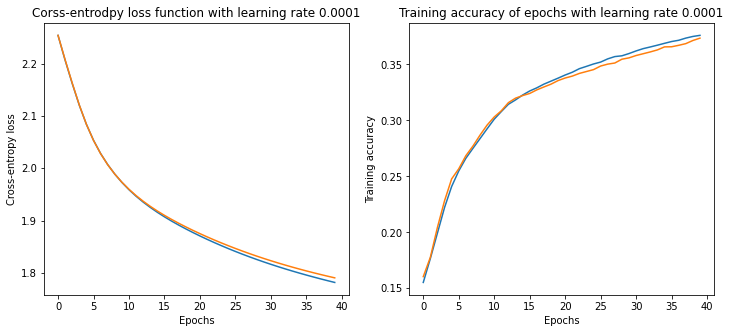

In [33]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train1)
plt.plot(losses_val1)
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.title("Corss-entrodpy loss function with learning rate 0.0001")

fig.add_subplot(122)
plt.plot(accuracies_train1)
plt.plot(accuracies_val1)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy of epochs with learning rate 0.0001")

plt.show()

**Interpretation**

From both graphs, we can conlcude that for the training data, the model converges very slowly: the lowest loss is around 1.7 and the highest accuracy is around 0.37. both blue and orange line are monotone and never diverge with respect to each other. This means that overfitting is highly reduced. However, the fact that the curves decrease or increase slowly also means that the to attein the optimal model, it would take more than 40 epochs. Indeed, for $\eta = 0.0001$ the loss function indicates that the learning rate and the gradient update the parameters little by little at every iteration. 

While overfitting is nearly avoided here, we have a very slow convergence leading to an accuracy arround 0.42 which could be improved. We could say that with this learning rate, the data is underfitted: the model does not capture the the true trend sufficiently and so its performance is not optimal. 

We will again run the same MLP with 40 epochs but this time with a larger learning rate $\eta = 0.1$ instead of 0.01, and we will then compare 3 models according to their loss and accuracy. 

In [34]:
W2,b2,losses_train2,accuracies_train2,losses_val2,accuracies_val2 = sgd(x_train,y_train,x_val,y_val,epochs=40,learning_rate=0.1)

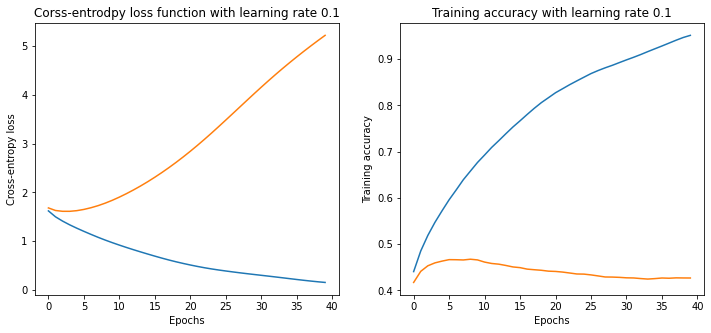

In [35]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train2)
plt.plot(losses_val2)
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.title("Corss-entrodpy loss function with learning rate 0.1")

fig.add_subplot(122)
plt.plot(accuracies_train2)
plt.plot(accuracies_val2)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy with learning rate 0.1")
plt.show()

**Interpretation**

From both graphs, we can conlcude that for the training data, the model converges very rapidly to 0 for loss and to 1 for accuracy. However, this also means that the overfitting (the divergence of performance of the model on the validation data) happens faster. Indeed, for $\eta = 0.01$ overfitting and divergence of the orange curve started after 10 epochs whereas, here with $\eta = 0.1$ it starts after the first 5 epochs and the difference gets larger and larger as the number of epochs increases: the performances on training data improve very fast and the loss function on validation data get worse very fast (the loss function is aroung 5 at the end of the training and keeps increasing). This high values loss function results mean that when the parameters are updated with the learning rate, they change considerabily. 

While the overfitting increases, convergence is very fast and we attein the optimal model (model at 5th epoch) faster: with best accuracy around 0.47. The model then stays realtively stable with accuracy 0.45. 

**Conclusion of influence of learning rate**

When comparing all 3 MLP neural networks we can conclude the inlfuence of the learning rate parameter. 

- Smaller learning rates require more training epochs given the smaller changes made to the weights and bias parameters each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

- A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

#### 1.1.3

To have a wider idea of convergence, we will train the 3 MLP models with learning rates $\eta = 0.1, 0.01, 0.0001$ but this time with 80 epochs. 

In [36]:
W3,b3,losses_train3,accuracies_train3,losses_val3,accuracies_val3 = sgd(x_train,y_train,x_val,y_val,epochs=80,learning_rate=0.01)

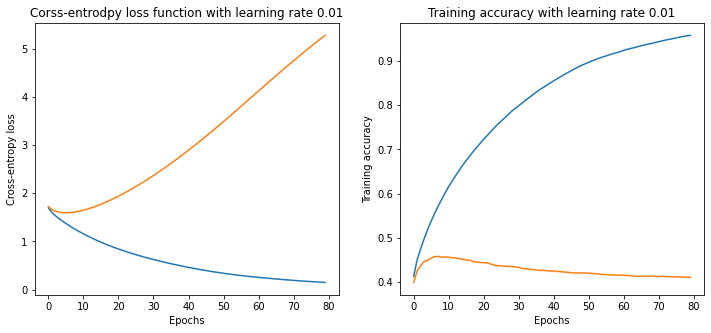

In [37]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train3)
plt.plot(losses_val3)
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.title("Corss-entrodpy loss function with learning rate 0.01")

fig.add_subplot(122)
plt.plot(accuracies_train3)
plt.plot(accuracies_val3)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy with learning rate 0.01")

plt.show()

In [38]:
W4,b4,losses_train4,accuracies_train4,losses_val4,accuracies_val4 = sgd(x_train,y_train,x_val,y_val,epochs=80,learning_rate=0.0001)

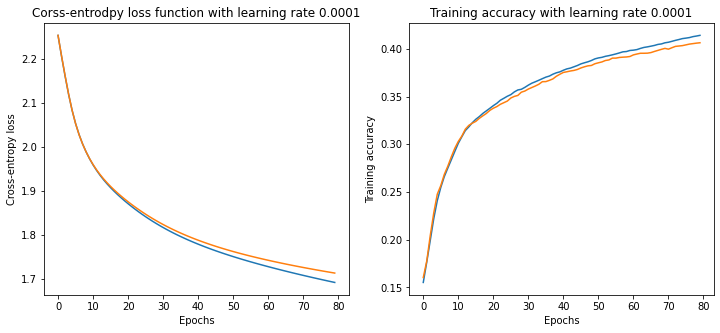

In [39]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train4)
plt.plot(losses_val4)
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.title("Corss-entrodpy loss function with learning rate 0.0001")

fig.add_subplot(122)
plt.plot(accuracies_train4)
plt.plot(accuracies_val4)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy with learning rate 0.0001")

plt.show()

In [40]:
W5,b5,losses_train5,accuracies_train5,losses_val5,accuracies_val5 = sgd(x_train,y_train,x_val,y_val,epochs=80,learning_rate=0.1)

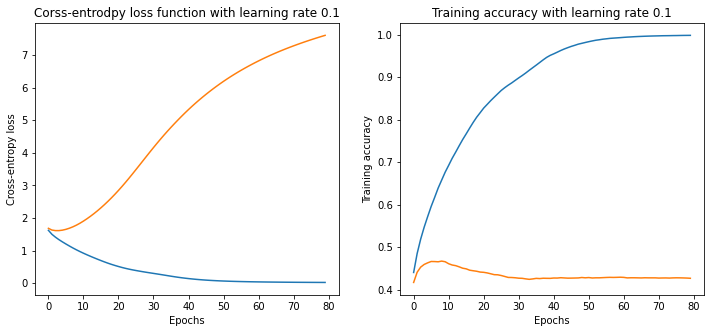

In [41]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train5)
plt.plot(losses_val5)
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.title("Corss-entrodpy loss function with learning rate 0.1")

fig.add_subplot(122)
plt.plot(accuracies_train5)
plt.plot(accuracies_val5)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy with learning rate 0.1")
plt.show()

**Conclusion**

**Influence of learning rate**

When comparing all 3 MLP neural networks we can conclude the inlfuence of the learning rate parameter. 

- Smaller learning rates require more training epochs given the smaller changes made to the weights and bias parameters each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

- A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

**Influence of number of epochs**

When comparing all MLP neural networks with 40 and 80 epochs, we look at the loss function. From the previous cases, we have two cases:

- if the validation error starts to increase, the model is over-fitting on training data, thus the learning process should be stopped. Therefore, if there is overfitting, select a smaller number of epochs. 

This is the case of our MLP models with $\eta = 0.01, 0.1$: for $\eta = 0.01$ the optimal number of epochs is 10 and for $\eta = 0.1$ the optimal number of epochs is 5. 

- if the validation error keeps decreasing and the model is not over-fitting, we can follow the "elbow method": set the optimal number of epochs at the elbow point. That is the point increasing the number of epoch make only slight difference in the loss function. 

This is the case of our MLP models with $\eta = 0.0001$, and we can set the elbow point to be at 10 epochs.

Therefore, for all 3 different learning rates, we do not need to train the model for 80 epochs and we could even shorten the training time to 15 epochs. 

To chose the best MLP model from the previous ones, we want to set the hyperparameters with a good trade off between over-fitting and under-fitting (with good performances). Therefore, we chose $\eta = 0.01$ and 40 epochs which has a high loss function indeed but a stable accuracy at aroung 0.45. 

Ideally, we would implement an MLP with:
-  a stopping criterion, allowing it to stop the training at around 10 epochs in this case, for the highest accuracy and lowest loss function. 
- less hidden layers and less neurons to reduce the number of parameters and therefore avoid overfitting.




Now, that we have chose our MLP model with the best performance, we can look at the confusion matrix to see where the model errors come from. The idea is to highlight the correct predictions, but mostly the main errors to see how we could improve the CNN model. 

In [42]:
def confusion_matrix(y_pred_val_10,y_val):
    n,d = y_val.shape
    confusion_matrix=np.zeros((d,d))
    for i in range(d): #actual
        for j in range(d): #predicted
            confusion_matrix[i,j] += sum(1 for k in range(n) if (y_val[k,i]==1)&(y_pred_val_10[k,j]==1))
    df_confusion = pd.DataFrame(confusion_matrix*10/n,index= ['airplane', 'automobile', 'bird', 'cat','deer', 'dog','frog','horse','ship','truck'],columns= ['airplane', 'automobile', 'bird', 'cat','deer', 'dog','frog','horse','ship','truck'])
    return df_confusion

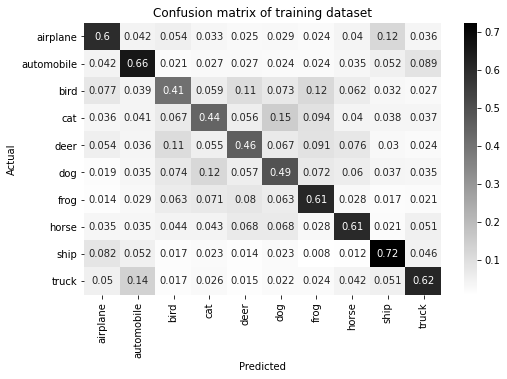

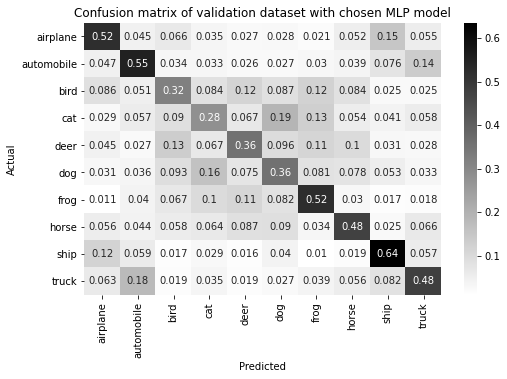

In [43]:
#validation set
y_pred_val,h_all_val,a_all_val = mlp(x_val,W,b)
y_pred_train,h_all_train,a_all_train = mlp(x_train,W,b)

#from predicted probability to predicted class
y_pred_10_val = prob_to_10(y_pred_val)
y_pred_10_train = prob_to_10(y_pred_train)

df_confusion_train = confusion_matrix(y_pred_10_train,y_train)
df_confusion_val = confusion_matrix(y_pred_10_val,y_val)

import seaborn as sns

plt.figure(figsize=(8,5))
sns.heatmap(df_confusion_train, annot = True,cmap='binary')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix of training dataset')
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(df_confusion_val, annot = True,cmap='binary')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix of validation dataset with chosen MLP model')
plt.show()

From both confusion matrices, we can see that the model performes better with non-animal images (ie. airplanes, automobile, ship, truck classes have accuracies between 0.5 and 0.6 approximately) than with animal images (ie. bird, cat,dog, deer, frog, horse have accuracies between 0.3 and 0.5 approximately). The main type of errors are between automobile and truck, airplane and ship, deer and bird, dog and cat, bird and cat, frog with all other animal etc. 

This can come from the fact that when we do not use convolutional layers, we mostly look at the colors of each pixel (from the colour chanels) and their adjacent pixels but not necessarily on the summarised idea of the configuration of the image. 
In oter words, the poor results of the MLP using a linear pre-activation $W x +b$ at every layer could imply that our data is not linear. This seems to be true because the three colour chanels are studied side to side when in fact they should be summarised together into 1 value. 

We will see that the convo


Of course, this is not the optimal MLP model and we will see regularisation methods that will improve its performance in terms of accuracy and loss function and by changing the structure of the model. 



### 1.2 Convolutional neural network


In this section, we will implement convolutional neural network with a  different architecture and different regularisation methods to find the global optimal model to carry the supervised classification of images. 

We will put back the standardised data into the original RGB input in (32x32x3) dimensions. We do this to use the Tensorflow library. 

In [44]:
def reshape_to_image(x_train,x_val):
    x_train2=x_train.reshape((x_train.shape[0],32,32,3))
    x_val2=x_val.reshape((x_val.shape[0],32,32,3))
    return x_train2,x_val2

In [45]:
x_train,x_val=reshape_to_image(x_train,x_val)

#### 1.2.1

Firstly, a convolutional neural network (CNN) is a particular case of a MLP using convolutional layers instead of linear. By summarising the entire image (in our case with the three colour channels per pixel), the convolutional operation also reduces the number of parameters for each layer and potentially reduces over-fitting.

What is the convolutional operation and how does it treat non-linear data?

The convolutional operation layer acts like a pre activation function. In our case we deal with RGB input images and therefore we need a kernel tensor $\boldsymbol k \in \mathbb{R}^{3 \mathrm{x} 3}$ to apply 3x3 feature maps to our convolutional layers. Using the fromula of the kernel, also called the filter:
$$
(\boldsymbol h * \boldsymbol k)(i,j) = \underset{m,n,p}{\sum} h(i+m,j+n,p) k (m,n,p)
$$
the convolutional layer operation becomes what is called the feature map 
$$
\boldsymbol h^{(k)} = \sigma \left( (\boldsymbol h^{(k-1)} * \boldsymbol h^{(k-1)}) +  \boldsymbol b^{(k-1)})\right)
$$
where k = 1,2,3 indexes the three convolutional layers and $\boldsymbol b^{(k-1)}$ is the associated bias. 

The role of the kernel is to sweep over the image to obtain summarising outputs (the neuron pre activations) from blocks of size 3x3x3of the previous layer. 

Another operation we will use is the max pooling layers in between all convolutional layers. 
Its role is to take the maximum activation of 2x2 squares of outputs of the feature maps. The aim is not only to downsample the spatial dimension, but also to detect the borders of a shape in an image. 

You should now build the CNN model in TensorFlow to train on the HAR dataset. This model should consist of:

* A first `Conv2D` convolutional layer with with 32 feature maps of size 3x3 and a ReLU activation
* A `MaxPooling2D` layer with a pooling window size of 2x2
* A second `Conv2D` convolutional layer with with 64 feature maps of size 3x3 and a ReLU activation
* A `MaxPooling2D` layer with a pooling window size of 2x2
* A third `Conv2D` convolutional layer with with 64 feature maps of size 3x3 and a ReLU activation
* A `MaxPooling2D` layer with a pooling window size of 2x2
* A `Flatten` layer
* A `Dense` layer with 64 neurons and a ReLU activation
* A `Dense` layer with 10 neurons and a softmax activation

The function below should build and compile this model, using an SGD optimizer with learning rate 0.01, 40 epochs and a categorical cross-entropy metric.

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

def get_model():
    model = Sequential([
        Conv2D(32, 3, activation='relu', input_shape=(32,32,3)),
        MaxPooling2D(2),
        Conv2D(64, 3, activation='relu'),
        MaxPooling2D(2),
        Conv2D(64, 3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    opt=SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

We can get a more detailed summary of the model.

In [47]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Before even training the model, we see that the number of parameters 122,570 is considerably smaller (compared to 1,873,610 in the MLP) indicating that the overfitting should be largely reduced. 

The kernel used should also fit the data more (since we have seen in 1.1 that hidden layer with linear pre activation is not ideal for RGB images). 

In [48]:
# Load the data into Dataset objects

train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_data = train_data.shuffle(1024)
train_data = train_data.batch(128)

val_data = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
val_data = val_data.batch(128)

train_data.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

Let's build the CNN, and train the model.

In [49]:
# Train the model, using early stopping

from tensorflow.keras.callbacks import EarlyStopping

def train_model(model):
    history = model.fit(train_data, epochs=40, verbose=0, validation_data=val_data)
    return history

history = train_model(model)

Similarly, to 1.1 we will evaluate the results by plotting the cross-entropy loss function and accuracy per epoch. 

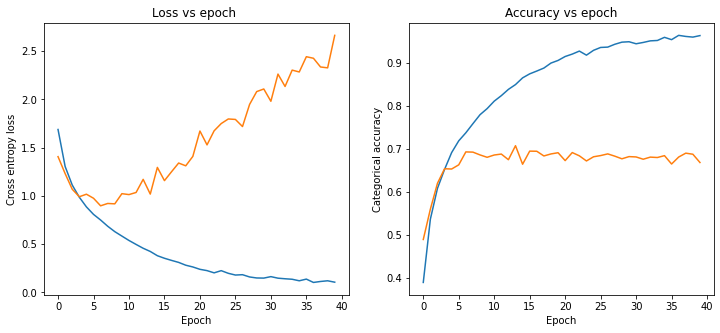

In [50]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch ")

fig.add_subplot(122)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")

plt.show()

**Interpretaion**

Clearly, we can detect over-fitting from two things:
- the divergence of the blue (training set) and orange (validation set) curves. This divergence happen at around the 10 epochs. 
- the convergence of the performance of the model on training data: to 0 for the loss-function and to 1 for the accuracy. This convergence appears after 15 epochs approximately (what we call the "elbow point"). 

**Comparison**

Comparing this with the previous models, we see that the convergence is considerably less stable: the performances fluctuates from one epoch to the other. This fluctuation can come from two things:
- we are not working with batch of data that are randomly selected but with block of data selected by the feature map.
- the number of parameters is considerably lower

#### 1.2.2

In this section, we will train a similar model to 1.2.1 but this time adding and L2 regularisation coefficient in all convolutional layers. 

A L2 regularisation coefficient is added to the cross-entropy loss function, as follow:
$$
L(\boldsymbol w, \alpha_2) = L_{0}(\boldsymbol w) + \alpha_2 \underset{i}{\sum} w_i^2
$$
where $L_0$ is the unconstrained cross-entropy loss function, $\alpha_2$ is the regularisation coefficient and $w_i$ are the weights assigned to the features in the convolution operation. This regularisation term acts like the regularisation term of the ridge regression we have seen in lecture. Its aim is to reduce overfitting by reducing the burden on these weights. Indeed since there are a lot of features then there will be a large number of weight but thanks to this regularisation term (usually very small), the weights end up having less impact on the loss function. Therefore, we shouldn't have an increasing loss function for the validation data. 
 

Let's build the CNN with convolutional layers using an L2 kernel weight regularisation with coefficient of 5e-3.

In [51]:
def get_model_reg():
    model = Sequential([
        Conv2D(32, 3, activation='relu', kernel_regularizer=l2(5e-3), input_shape=(32,32,3)),
        MaxPooling2D(2),
        Conv2D(64,3,activation='relu',kernel_regularizer=l2(5e-3)),
        MaxPooling2D(2),
        Conv2D(64,3,activation='relu',kernel_regularizer=l2(5e-3)),
        Flatten(),
        Dense(64, kernel_regularizer=l2(5e-3), activation='relu'),
        Dense(10, kernel_regularizer=l2(5e-3), activation='softmax')
    ])
    opt=SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [52]:
model_reg = get_model_reg()

In [53]:
history_reg = train_model(model_reg)

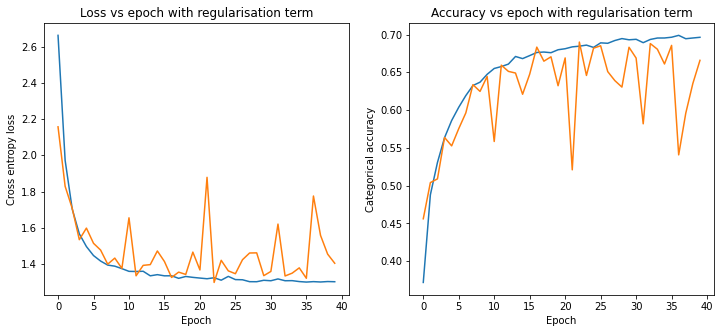

In [54]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_reg.history['loss'], label='Train')
plt.plot(history_reg.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch with regularisation term")

fig.add_subplot(122)
plt.plot(history_reg.history['accuracy'], label='Train')
plt.plot(history_reg.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch with regularisation term")

plt.show()

**Interpretation**

From the graph, we can see that the regularisation coefficient has a significant effect in avoiding the over-fitting. Indeed, in this trained model, the blue and orange curve do not diverge (for both accuracy and loss function). This implies that, the data is not over-fitted. Also, the loss-function converges to 1.2 after approximately 10 epochs and the accuracy converges to approximately 0.7.


**Comparaison**

Firsly, when looking at the plots in their entirity, the flucutations of the performances with respect to epochs seem to have gotten worse but in reality they have very similar amplitude to the previous model. 

Comparing this with the previous CNN, the over-fitting is not appearing anymore. In the model with the regularisation term, the converging accuracy of the validation does not change, but the converging value of the loss function in the training function stays relatively constant (around 1.4). This is a big improvement when comparing it with the previous model with loss-function on validation data diverging to large values. 

Therefore, the regularisation term has indeed reduced the impact of the weights on the loss function, as required. This not only reduces the loss function from the plot, but it also influences the SGD optimiser results. Indeed, during the backpropagation, the parameters are updated by taking the gradient of the loss function at each step. The regularisation term also influences the gradient, by reducing their values. Therefore, the regularizers penalize the parameters of the model thanks to the regulirisation term. 


#### 1.2.3

##### Dropout

Another regularisation method is the Dropout method. Its aim is to reduce overfitting as well by droping some random nodes in your layers in the neural network.
Here, we will implement Droupout in some layers with rate 0.5.

Usually, dropout is placed on the fully connected layers or dense layers only because they are the ones with the greater number of parameters and thus they’re likely to cause overfitting. However, after trying out all the combinations of where to place dropout, the optimal results are obtained for dropout implemented after the two maxpooling layers. 

In [55]:
from tensorflow.keras.layers import Dropout

def get_model_reg2():
    model = Sequential([
        Conv2D(32, 3, activation='relu', input_shape=(32,32,3)),
        MaxPooling2D(2),
        Dropout(0.5),
        Conv2D(64, 3, activation='relu'),
        MaxPooling2D(2),
        Dropout(0.5),
        Conv2D(64, 3, activation='relu'),
        #Dropout(0.5),
        Flatten(),
        Dense(64, activation='relu'),
        #Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    opt=SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [56]:
model_reg2 = get_model_reg2()
history_reg2 = train_model(model_reg2)

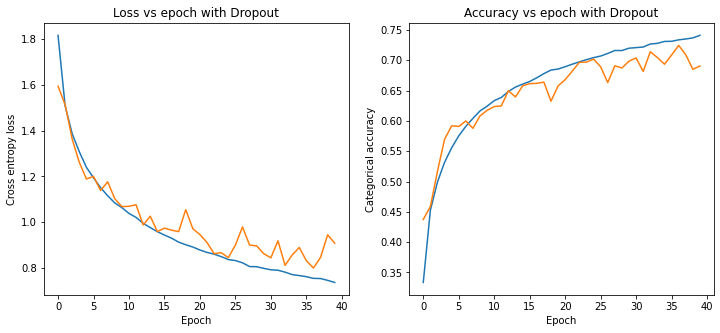

In [57]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_reg2.history['loss'], label='Train')
plt.plot(history_reg2.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch with Dropout")

fig.add_subplot(122)
plt.plot(history_reg2.history['accuracy'], label='Train')
plt.plot(history_reg2.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch with Dropout")

plt.show()

With droupout, parameters are not sparse like with the L2 regularisation method, they are deleted. Therefore, the loss function does not fluctuate so much when the parameters are updated (with the SGD optimiser). So the dropout model gives better results than the L2 regularisation method. 

Comparing the plots with Droupout command to the previous ones, we realise that:
- it reduces the variations of loss and accuracy widely
- the convergence stays the same: happening around the 10th epoc 
- overall the scores the performances converge to are better: 0.8 for loss function and 0.72 for accuracy. These results are improved compared to the L2 regularisation and the non regularised trained model.

Therefore, so far this technique is the best: it is very robust because it avoids overfitting overall while giving stable (non-variant) and satisfying results. 


##### Early stopping

The last regularisation method we will implement is the early stopping method. The aim of this method is to stop  training the model once the validation loss function is at its minimum. This algorithm depends on the parameter patience, which is the maximum number of values of loss functions for which the loss function does not improve. In other words, if patience=5, then the algorithm will stop after 5 values of increasing loss function. We have chosen the patience tobe equal to 5, because it is a good trade off between how close it is to the actual minimal point and it avoids confusing increasing loss and non-meaningful fluctuations. Indeed, we should avoid having to many fluctuations. 

Let's train the model and observe the results. 

In [58]:
def train_model_es(model):
    early_stopping = EarlyStopping(monitor='val_accuracy',patience=5)
    history = model.fit(train_data, epochs=40, verbose=0, validation_data=val_data, callbacks=[early_stopping])
    return history

In [59]:
model_reg3 = get_model()
history_reg3 = train_model_es(model_reg3)

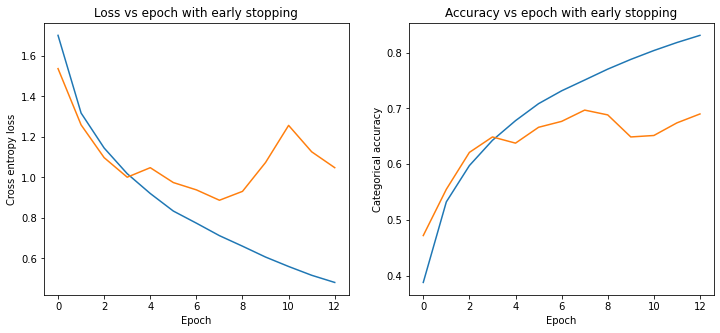

In [60]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_reg3.history['loss'], label='Train')
plt.plot(history_reg3.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch with early stopping")

fig.add_subplot(122)
plt.plot(history_reg3.history['accuracy'], label='Train')
plt.plot(history_reg3.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch with early stopping")

plt.show()

When trying different values of patience to find the one which avoids overfitting while giving good accuracy and loss results. Instead of running the algorithm over 40 epoches, the early stopping, will shorten the algorithm to 12 epochs. This is coherent with the previous non-regularised CNN model. 

- The advantage of this technique is that the  running time is short and it stops just a few epochs after the optimal model. 
- The disadvantage is that there is still a little bit of  overfitting (the blue curve doesn't seem to be converging yet) and the final results of the accuracy and loss function can be improved (around 1.2 for validatin loss and 0.68 for validation accuracy).

Let's summarise the results obtained for the three regularisation methods: L2 regularization, Dropout and Early stopping. 

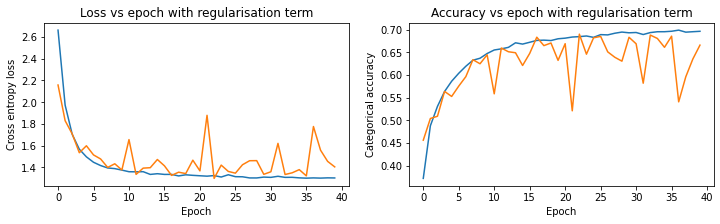

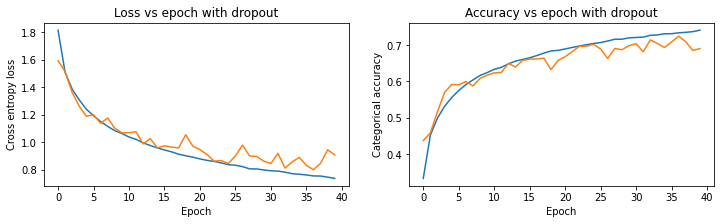

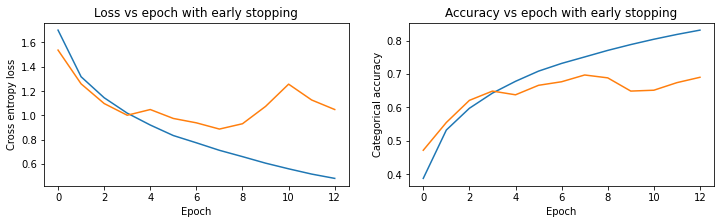

In [61]:
fig = plt.figure(figsize=(12, 3))

fig.add_subplot(121)
plt.plot(history_reg.history['loss'], label='Train')
plt.plot(history_reg.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch with regularisation term")

fig.add_subplot(122)
plt.plot(history_reg.history['accuracy'], label='Train')
plt.plot(history_reg.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch with regularisation term")
plt.show()

fig = plt.figure(figsize=(12, 3))
fig.add_subplot(121)
plt.plot(history_reg2.history['loss'], label='Train')
plt.plot(history_reg2.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch with dropout")

fig.add_subplot(122)
plt.plot(history_reg2.history['accuracy'], label='Train')
plt.plot(history_reg2.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch with dropout")
plt.show()

fig = plt.figure(figsize=(12, 3))

fig.add_subplot(121)
plt.plot(history_reg3.history['loss'], label='Train')
plt.plot(history_reg3.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch with early stopping")

fig.add_subplot(122)
plt.plot(history_reg3.history['accuracy'], label='Train')
plt.plot(history_reg3.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch with early stopping")

plt.show()

We can again conclude that the Droupout regularisation method is the optimal one:
- most robust: small fluctuations of validation performance
- least over-fitting: no divergence of validation performance
- best performance: validation loss arounf 0.9 and validation accuracy around 0.7

#### 1.2.4

Let's now compare the MLP model from 1.1.1 (with learning rate 0.01 and 40 epochs) and the best CNN model (with Dropout) in terms of cross-entropy loss function and accuracy. 

The learning rate and the number of epochs are the same. However, the MLP model deals with the data linearly and with a large amount of data, whereas the regularised model of 1.2.3 deals with data with a kernel in 3 dimensions from convolutional operation and uses less parameters thanks to the Droupout with rate 0.5 after the convulutional layers. 

**Performances**

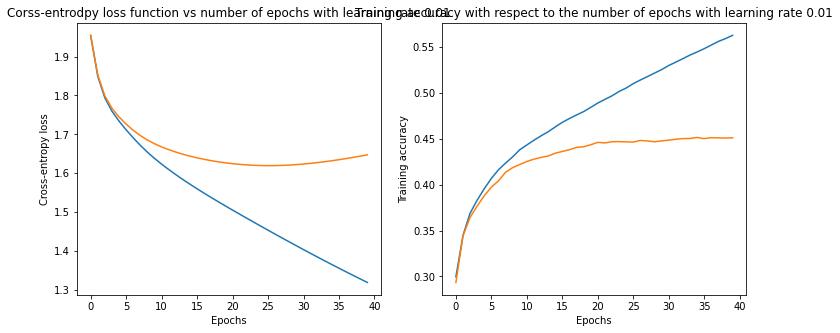

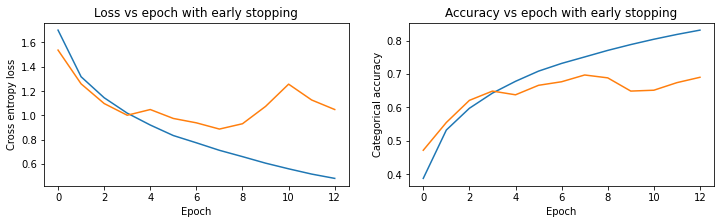

In [62]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.title("Corss-entrodpy loss function vs number of epochs with learning rate 0.01")

fig.add_subplot(122)
plt.plot(accuracies_train)
plt.plot(accuracies_val)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Training accuracy with respect to the number of epochs with learning rate 0.01")

plt.show()

fig = plt.figure(figsize=(12, 3))

fig.add_subplot(121)
plt.plot(history_reg3.history['loss'], label='Train')
plt.plot(history_reg3.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch with early stopping")

fig.add_subplot(122)
plt.plot(history_reg3.history['accuracy'], label='Train')
plt.plot(history_reg3.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch with early stopping")

plt.show()

**Training time**

Here, we train the CNN model without the GPU for the comparison to be meaningful (because with a GPU tensorflow trains the models in a few seconds only). 

In [63]:
import time 
from time import process_time
# Start the stopwatch / counter 
t_start_reg3 = process_time() 
history_reg3 = train_model(model_reg3)
# Stop the stopwatch / counter
t_stop_reg3 = process_time()

t_cnn1 = t_stop_reg3 - t_start_reg3

We get the following computational time for training MLP model from 1.1.1 and CNN model from 1.2.3 : 

In [66]:
print("Computational time for training MLP model 1.1.1 without Dropout :", t_mlp)
print("Computational time for training CNN model 1.2.3 with Dropout with GPU:", t_cnn1) 

Computational time for training MLP model 1.1.1 without Dropout : 4252.217992743
Computational time for training CNN model 1.2.3 with Dropout : 123.82973906300322


Finally to compare the number of parameters in the model, we show the summary of the CNN model with Droupout.

In [4]:
print("Number of parameters in the MLP model 1.1.1 without Dropout :", 1,873,610)
print("Number of parameters in the CNN model 1.2.3 with Dropout :", 94,890) 

Number of parameters in the MLP model 1.1.1 without Dropout : 1 873 610
Number of parameters in the CNN model 1.2.3 with Dropout : 94 890


The difference of all the results could be highly linked. 

- Reducting the number of parameters with Droupout, reduces the training time and reduces overfitting.
- Using a non-linear kernel in the convolutional layers explains the better accuracies because the RGD images are not linear data. 

## Conclusion of Task 1

To conlcude on task 1, we could study the influence of different hyperparaters for the MLP:
- learning rate: small learning rate can lead to under-fitting (the parameters are sweeped too slowly) while large learning rate can lead to over-fitting (the parameters are sweeped too rapidly). 
- the number of epochs: lower number of epochs can reduce overfitting and higher number of epochs can reduce under-fitting and improve performances. 

We can also study the influence of different regularisation methods for CNN models:
- L2 regularisation method highly reduces overfitting by reducing weights for each parameter
- Dropout with rate 0.5 reduces the number of parameters considerably and therefore reduces over-fitting.
- Early Stopping stops the training close to the minimal loss function before over-fitting happens.

Coming back to their application with our set of images, we can conclude that the CNN model using non-linear model and Max pooling layers is more adequate to get an idea of the image overall and to spot the edges within the image. Therefore, the model with Droupout in 1.2.3 would be the optimal model to use for classification. 

It is robust, performant, avoids over-fitting and is relatively fast with a GPU. 

## 2. Unsupervised learning

In task 2, we will study 3 unsupervised learning methods: k-means clustering algorithm, Principal Component analysis (PCA) and Graph-based analysis. We are given two different datasets for the same problem: Zachary's karate club. Inside Zacharys's karate club, a conflict arose between the administrator "Officer" and instructor "Mr. Hi", which led to the split of the club into two. Out of the 34 members, some members formed a new club around Mr. Hi; other members found a new instructor; others gave up karate. 

We are given two datasets to analyse, and one dataset with the results of the split. Let's first upload the 3 files to study.

In [6]:
from google.colab import files
import io 
uploaded=files.upload()
feature = pd.read_csv (io.BytesIO(uploaded['feature_matrix_karate_club.csv']))

Saving ground_truth_karate_club.csv to ground_truth_karate_club.csv
Saving karate_club_graph.csv to karate_club_graph.csv
Saving feature_matrix_karate_club.csv to feature_matrix_karate_club.csv


In [7]:
ground_truth = pd.read_csv(io.BytesIO(uploaded['ground_truth_karate_club.csv']))

In [8]:
graph = pd.read_csv(io.BytesIO(uploaded['karate_club_graph.csv']))

In [9]:
feature = np.asarray(feature)
ground_truth = np.asarray(ground_truth)
graph = np.asarray(graph)

We delete the first column which is simply the index of the corresponding individual.

In [10]:
feature = feature[:,1:]
ground_truth = ground_truth[:,1:]
graph = graph[:,1:]

The two sets of collected data to study are `feature` and `graph`, which are:

-  `feature`: a set of features characterising the personality profile of the 34 members. We are given as a feature matrix F $\in \mathbb{R}^{34 \mathrm{x} 100}$ where each row corresponds to an inidividual and each of the 100 columns correspond to a feature capturing different traits of personality. 
- `graph` : the social network of friendships capturing the 34 members (nodes) and the 78 fiendships between them (edges). We are given adjacent matrix A $\in \mathbb{R}^{34 \mathrm{x} 34}$ in which each element $A_{ij} = 1$ corresponds to a friendship betwen $i^{th}$ and $j^{th}$ members.

In [11]:
feature

array([[ 0.14864008, -0.18710981, -0.10939524, ...,  0.02139415,
        -0.0219182 ,  0.09143373],
       [ 0.20700055, -0.01897949, -0.09448294, ..., -0.03428907,
        -0.14576454, -0.02500351],
       [ 0.09396198, -0.26245123, -0.03301012, ..., -0.08545066,
        -0.02417422,  0.16861194],
       ...,
       [ 0.07163295,  0.02107777, -0.0286725 , ...,  0.07991265,
        -0.13502657, -0.03348165],
       [ 0.16400485, -0.13058038, -0.13862133, ...,  0.00711885,
         0.09925542,  0.15335855],
       [-0.00401106, -0.10642391, -0.10301867, ...,  0.049763  ,
        -0.14943294,  0.01960115]])

In [12]:
graph

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

-  `ground_truth`: the vector corresponding to the split of the karate club with the respective instructor.

In [13]:
ground_truth.T

array([['Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi',
        'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Officer', 'Mr. Hi', 'Mr. Hi',
        'Mr. Hi', 'Mr. Hi', 'Officer', 'Officer', 'Mr. Hi', 'Mr. Hi',
        'Officer', 'Mr. Hi', 'Officer', 'Mr. Hi', 'Officer', 'Officer',
        'Officer', 'Officer', 'Officer', 'Officer', 'Officer', 'Officer',
        'Officer', 'Officer', 'Officer', 'Officer']], dtype=object)

The data is finally ready to be used for the three methods we will study: 
- k-means clustering and PCA with the feature data
- graph analysis with the graph data

### 2.1 Clustering of the feature matrix

In [14]:
X=feature

#### 2.1.1

Taking the feature matrix F $\in \mathbb{R}^{34 \mathrm{x} 100}$, we will carry a k-means clustering according to the features of the individuals. 
K-means is a distance-based method whose goal is to split the data points into k clusters in the most optimal way. 

We chose to carry the k-means where similarity is measured with distance $D(\boldsymbol x^{(i)},\boldsymbol x^{(j)}) = \| \boldsymbol x^{(i)} - \boldsymbol x^{(j)} \|^{2}$ beacause our data is continuous. The aim of the algorithm is to minimise the distance within each cluster and maximise the distance in between each cluster.

Given a specific clustering $\mathcal{C} = \{ c_1, \cdots , c_k \} $, where $c_{l}$ is the $l^{th}$ cluster, we define the within distance $W$ and the between distance as:
$$
W(\mathcal{C}) = \frac{1}{2} \sum_{l=1}^{k} \sum_{i,j \in c_l}^{n_l} \| \boldsymbol x^{(i)} - \boldsymbol x^{(j)} \|^{2} \quad \quad \quad B(\mathcal{C}) = \frac{1}{2} \sum_{i=1}^{N} \sum_{j}^{N} \| \boldsymbol x^{(i)} - \boldsymbol x^{(j)} \|^{2} - W(\mathcal{C})
$$
where $\boldsymbol x^{(1)}, \cdots, \boldsymbol x^{(N)}$ are the N data points, $c_l$ is the $l^{th}$ cluster with its corresponding number of data points $n_l$. 

The between distance $B(\mathcal{C})$ depending on the within distance $W(\mathcal{C})$ will be maximised when the within distance $W(\mathcal{C})$ is minimised. 
Therefore, we set $W(\mathcal{C})$ to be the cost function, that we are trying to minimise. 
From the lecture notes, we have seen that the within distance is equivalent to the distance to the centroids, which is easier to compute:
$$
W(\mathcal{C}) = \frac{1}{2} \sum_{l=1}^{k} \sum_{i,j \in c_l}^{n_l} \| \boldsymbol x^{(i)} - \boldsymbol x^{(j)} \|^{2} = \sum_{l=1}^{k} \sum_{i \in c_l}^{n_l} \| \boldsymbol x^{(i)} - \boldsymbol m_{l} \|^{2} 
$$
where $\boldsymbol m_{l}$ is the centroid of the $l^{th}$ cluster computed by taking the mean of the points in the cluster.

The aim of the k-means algorithm is to minimise $W(\mathcal{C})$, which we will compute from the distance to the centroids. 

Now, to minimise $W(\mathcal{C})$ given a number of clusters k, the algorithm proceeds to iterations as follow:
- Step 1: Randomly, assign to every sample a label from 0 to k-1 corresponding to their cluster. To guarantee that the k-means algorithm creates indeed k non-empty clusters, we implement a while loop to make sure that each label is assigned at least once. 
- Step 2: For each of the k cluster compute the centroid of each cluster as: 
$$ 
\boldsymbol m_{l} = \frac{1}{|c_l|} \sum_{i \in c_l}^{n_l} \boldsymbol x ^{(i)} 
$$ 
- Steps 3: For each data point $\boldsymbol x^{(i)}$, compute the distances with each centroid $\| \boldsymbol x^{(i)} - \boldsymbol x_{l} \|^{2} $ for $l=1,\cdots,k$ and assign $\boldsymbol x^{(i)}$ to the 

- Step 4: Iterate steps 1 and 2 until "convergence". Since the problem is combinatorial, "convergence" means that step 2 and 3 do not bring any change to the labels.

In [15]:
def centroid_no_empty(X,k):
    n_samples, n_features = X.shape
    labels=np.array([1])
    
    #step 1: assign every sample to a cluster at random
    while np.unique(labels).shape[0] < k: # make sure every label is assigned at least once 
        labels = np.random.randint(low=0, high=k, size=n_samples) # randomness of initialisation comes from this line
        X_labels = np.append(X, labels.reshape(-1,1), axis=1)
        
    # step 2: computing the centroids of each of the k clusters
    centroids = np.zeros((k,n_features))
    for i in range(k):
        centroids[i,:] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]
    
    return centroids,labels

In [16]:
def k_means(X,k,show_iterations=None):
    max_iter = 20
    new_labels = np.zeros(len(X)) #one label per observation
    difference = 0
    average_distance=np.zeros(max_iter)
    
    # k-means algorithm:
    # step 1 and 2
    centroids,labels=centroid_no_empty(X,k)
    
    # step 3:
    for i in range(max_iter):
        #print(i,'th iteration')
        # distances between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # update unchanged labels
            labels = new_labels
            break
        else:
            # update changed labels
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            if show_iterations == 1:
                print('iteration', i+1, ': %4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)  
    
    return centroids,labels

In [19]:
k=4
centroids,labels=k_means(X,4,show_iterations=1)

iteration 1 : 58.823529% labels changed
iteration 2 : 20.588235% labels changed
iteration 3 : 5.882353% labels changed


In general for our data it takes between 2 and 5 iterations for the kmeans algorithm to "converge" to the optimal clustering.

The resulting clustering depends on the random initialisation of step 1. Since the initialisation randomness does not guarantee to attein the global optimal clustering, we will run the kmeans algorithm 100 times and chose the global optimal clustering to be the clustering with the minimal cost function W out of the ensemble of 100 resulting optimised clusterings. 


Now, to chose the optimal number of clusters $k^{*}$, the first measure of 'goodness' we will study is of average within-cluster distance. If we refer to our lecture notes, it refers to the average of the matrix W(C), over the 100 initialisations.

Set $W_k$ to be the average within-cluster distance for the 100 random iterations of kmeans with k clusters. 
$$
W_k = \frac{1}{100} \sum_{j=1}^{100} W(\mathcal{C}_j) = \frac{1}{100} \sum_{j=1}^{100} \left[ \sum_{l=1}^{k} \sum_{i \in c_{l}} \| x^{(i)} - c^{(l)} \|^{2} \right]
$$
where $\mathcal{C}_j$ is the resulting clustering of the $j^{th}$ initialisation. 
We will use the results of the average within-cluster distance for two things:
- chose the optimal number of clusters k
- chose the optimal clustering from the global optimal clustering for each k 

In [20]:
def within_cluster_distance(centroids,labels,X,k):
    average_distance = np.zeros(k)
    #compute normalised distance for each cluster
    for l in range(k):
        c=centroids[l,:] #centroid of cluster l 
        if (labels == l).any():
            average_distance[l] = np.sum(np.square(np.linalg.norm(X[labels==l]-c)))
    return np.sum(average_distance)

In [21]:
def k_means_all(X):
    average_distances = np.zeros((9,100))
    labels_all = [] 
    for k in range(2,11):
        for j in range(100):
            centroids,labels = k_means(X,k)
            average_distances[k-2,j] = within_cluster_distance(centroids,labels,X,k)
            labels_all.append(labels)
    return average_distances,labels_all

In [22]:
average_distance,labels_all = k_means_all(X)

Let's plot the average of the within-cluster distance and the within-cluster distances of the optimal clusterings for each number of clusters k. 

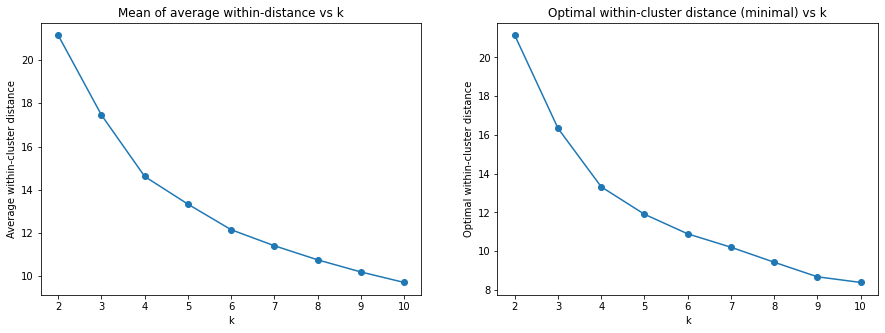

In [23]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(np.array(range(2,11)),np.mean(average_distance,axis=1),'o-')
plt.xlabel("k")
plt.ylabel("Average within-cluster distance")
plt.title("Mean of average within-distance vs k")

fig.add_subplot(122)
plt.plot(np.array(range(2,11)),np.min(average_distance,axis=1),'o-')
plt.xlabel("k")
plt.ylabel("Optimal within-cluster distance")
plt.title("Optimal within-cluster distance (minimal) vs k")

plt.show()

The average within-cluster distance is an indicator of the cost function. In lectures, we have seen that the optimal k should be chosen as follow: find the smallest k for which $W(\mathcal{C})$ is small, ie. for decreasing $W(\mathcal{C})$, find k such that the clustering results no longer improve. 
Graphically, this means that the optimal k is where the 'elbow' of the plot is located. 
From the graph, we can see that k=4 would be the optimal number of clusters. 

Let's plot the within-cluster distances for each k and each initialisation to have a visual idea of where the global optimal clustering stands with respect to the other clusterings. 

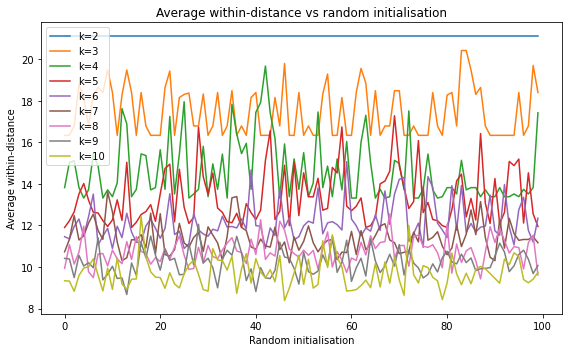

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average within-distance')
ax.set_xlabel('Random initialisation')
ax.set_title('Average within-distance vs random initialisation')
ax.plot(np.array(range(100)),average_distance[0,:].T,label='k=2')
ax.plot(np.array(range(100)),average_distance[1,:].T,label='k=3')
ax.plot(np.array(range(100)),average_distance[2,:].T,label='k=4')
ax.plot(np.array(range(100)),average_distance[3,:].T,label='k=5')
ax.plot(np.array(range(100)),average_distance[4,:].T,label='k=6')
ax.plot(np.array(range(100)),average_distance[5,:].T,label='k=7')
ax.plot(np.array(range(100)),average_distance[6,:].T,label='k=8')
ax.plot(np.array(range(100)),average_distance[7,:].T,label='k=9')
ax.plot(np.array(range(100)),average_distance[8,:].T,label='k=10')
ax.legend()

fig.tight_layout()

plt.show()

According to the average within-cluster distance, the optimal clustering has 4 clusters and the minimal. From our 100 iterations, it is the following:

In [28]:
k=4
labels_W = labels_all[(k-2)*100 + np.argmin(average_distance[(k-2),:])]
print('The global optimal clustering with k=4 is:')
print(labels_W)
unique,count=np.unique(labels_W,return_counts=True)
print('The values count is', count, 'for clusters', [0,1,2,3])

The global optimal clustering with k=4 is:
[3 0 3 0 0 1 0 1 0 3 2 2 0 3 1 3 1 2 2 3 1 0 2 3 3 3 0 3 3 0 3 0 3 0]
The values count is [11  5  5 13] for clusters [0, 1, 2, 3]


To put it back in context, this would mean that this clustering is the optimal way of creating 4 groups of similar individuals according to the feature of personality traits.

#### 2.1.2

Let's introduce the Calinski-Harabasz score (CH score) for a k-means clustering $\mathcal{C} = \{c_{l}\}_{l=1}^{k}$ :

$$
CH = \frac{B(k)/(k-1)}{W(k)/(n-k)}
$$

where $W(k)$ is the within-cluster sums of squares for the k clusters:
$$
W(\mathcal{C}) = \sum_{l=1}^{k} \sum_{i \in c_{l}} \| x^{(i)} - c^{(l)} \|^{2}
$$

Equivalently,
$$
B(\mathcal{C}) = \sum_{l=1}^{k} \left[ n_{l} \| c^{(l)} - c \|^2 \right]
$$
where $c$ is the global centroid (calculated by taking the mean of all data points) and for each cluster $c_{l}$ is the $l^{th}$ cluster mean and $n_{l}$ is the number of points in that $l^{th}$ cluster. 
The function bellow computes the in-between distance as bellow. 

In [29]:
def pairwise_distances(points):

    N= points.shape[0]
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sum(points[i, :] - points[j, :])**2 #sum of squares
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

The following function computes the in between distances according to the second version of the fromula. 

In [30]:
def between_distance2(centroids,labels,X,k):
    #return labels of cluster and number of points in cluster
    unique,counts=np.unique(labels,return_counts=True)
    c = np.mean(X,axis=0)
    dist_clust = 0
    #calculate in between distance wrt global centroid with weighted average 
    for l in range(k):
        dist_clust += counts[l]*np.linalg.norm(centroids[l] - c)**2
    return dist_clust

The function bellow comptes the CH score of a given clustering (stored in labels).

In [31]:
def ch(centroids,labels,X,k):
    dist_clust = between_distance2(centroids,labels,X,k)/(k-1)
    dist_total = within_cluster_distance(centroids,labels,X,k)/(X.shape[0]-k)
    ch = dist_clust / dist_total 
    return ch

Let's now evalutate the CH_score of the resulting clustering of the 100 initialisations for k = 2, ...,10. 

In [32]:
def ch_all(X):
    labelss=[]
    #ch_all = np.zeros((9,100))
    ch_all=np.zeros((9,100))
    optimal_labels=np.zeros((9,X.shape[0]))

    for k in range(2,11):
        for j in range(100):
            labels=np.array([0])
            while np.unique(labels).shape[0] < k:
                centroids,labels = k_means(X,k)
            labelss.append(labels)
            ch_all[k-2,j] = ch(centroids,labels,X,k)
        
        optimal_labels[k-2,:] = labelss[np.argmax(ch_all[k-2,:])+100*(k-2)]
    return ch_all,labelss,optimal_labels

In [45]:
chs,labels,optimal_labels = ch_all(X)

According to my research, higher values of CH index mean the clusters are dense (from minimised within-distance) and well separated (from maximised in between distance). Ideally, the global optimal clustering solution gives a peak or at least an abrupt elbow on the line plot of CH indices. Otherwise, if the line is smooth (horizontal or ascending or descending) then there is no such reason to prefer one solution over others. 


In [46]:
labels_km = optimal_labels[0]
labels_km

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])

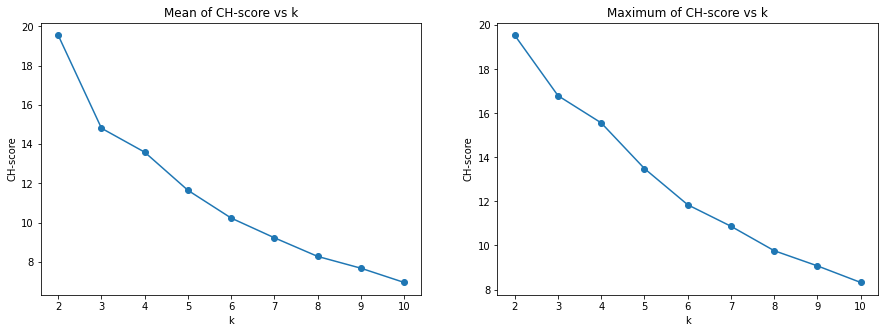

In [47]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(np.array(range(2,11)),np.mean(chs,axis=1),'o-')
plt.xlabel("k")
plt.ylabel("CH-score")
plt.title("Mean of CH-score vs k")

fig.add_subplot(122)
plt.plot(np.array(range(2,11)),np.max(chs,axis=1),'o-')
plt.xlabel("k")
plt.ylabel("CH-score")
plt.title("Maximum of CH-score vs k")

plt.show()


Therefore, we can interpret the resulting plots in two different ways to get the optimal k:
- 1. If we consider that the plot is simply a decreasing smooth line then there is no optimal clustering
- 2. If we take the maximum CH-score, we could conclude that k=2 is the optimal number of clusters.

We will consider the second interpretation, which explains that the karate club should be split in two. From the 100 clusterings obtained with k=2, we will chose the global optimal one with the highest CH-score. 

The reason why we do not necessarily see a peak in the CH-score plot is because the sample size 34 is very small and therefore, the impact of random initialisations can be very significant. We can see this impact on the next plot.  

Another, argument that reinforces our choice of k=2 is to check how the CH-score vary according to the random 100 initialisations. 

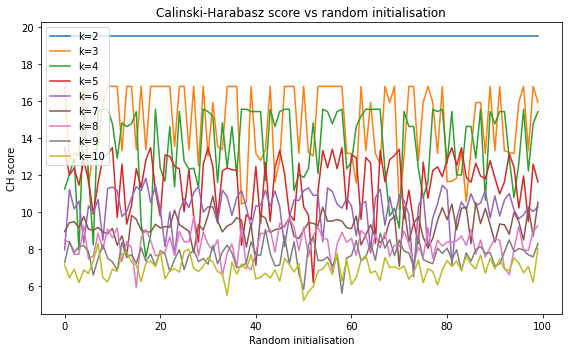

In [48]:
fig, ax = plt.subplots(figsize=(8,5))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('CH score')
ax.set_xlabel('Random initialisation')
ax.set_title('Calinski-Harabasz score vs random initialisation')
ax.plot(np.array(range(100)),chs[0,:].T,label='k=2')
ax.plot(np.array(range(100)),chs[1,:].T,label='k=3')
ax.plot(np.array(range(100)),chs[2,:].T,label='k=4')
ax.plot(np.array(range(100)),chs[3,:].T,label='k=5')
ax.plot(np.array(range(100)),chs[4,:].T,label='k=6')
ax.plot(np.array(range(100)),chs[5,:].T,label='k=7')
ax.plot(np.array(range(100)),chs[6,:].T,label='k=8')
ax.plot(np.array(range(100)),chs[7,:].T,label='k=9')
ax.plot(np.array(range(100)),chs[8,:].T,label='k=10')
ax.legend()

fig.tight_layout()

plt.show()

The CH-score can intuitivelly be understood as analogous to an F-ratio in ANOVA; 𝐵(𝑘) in between-cluster sums of squares (with k-1 degrees of freedom) and 𝑊(𝑘) is within-cluster sums of squares (with n-k degrees of freedom) for the 𝑘 clusters.
$$CH = \frac{B(k)/(k-1)}{W(k)/(n-k)}$$

When 𝑘 increases, if the clusters were all actually just from the same population, 𝐵 should be proportional to 𝑘−1 and 𝑊 should be proportional to 𝑛−𝑘. 

So by scaling for those degrees of freedom, it puts them  on the same scale (apart, of course, from the effectiveness of the clustering, which is what the index attempts to measure). We could see the CH-score as a normalised score with respect to the number of clusters k.  

Therefore, we priorities the results from the CH-score as opposed to the within-cluster distance because it takes in account the variability of the results when k is larger. 
Therefore, so far the optimal clustering has 2 clusters. 



#### 2.1.3 Evaluate the robustness of the clustering 

To evaluate the robustness (involving its consistency and its variability) with respect to the random initialisation we will use three criterias. 
- the variance of the within-cluster distances for the 100 kmeans clusterings (for each k)
- the variance of the CH scores for the 100 kmeans clusterings (for each k)
- the variability of the clusterings themself by computing the average similarities (with the Adjusted Rand Index) between each possible pair of clusterings (from the 100 clusterings).



#### Variability of cost function W

Using the results from 2.1.1, we can simply compute and plot the values of the variances of the within-cluster distance of the 100 clusterings obtaines from random initialisation (for each k).

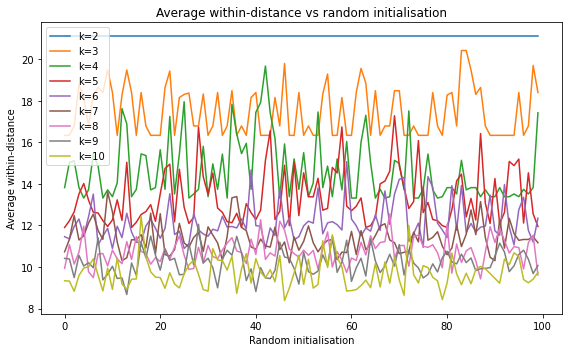

In [49]:
fig, ax = plt.subplots(figsize=(8,5))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average within-distance')
ax.set_xlabel('Random initialisation')
ax.set_title('Average within-distance vs random initialisation')
ax.plot(np.array(range(100)),average_distance[0,:].T,label='k=2')
ax.plot(np.array(range(100)),average_distance[1,:].T,label='k=3')
ax.plot(np.array(range(100)),average_distance[2,:].T,label='k=4')
ax.plot(np.array(range(100)),average_distance[3,:].T,label='k=5')
ax.plot(np.array(range(100)),average_distance[4,:].T,label='k=6')
ax.plot(np.array(range(100)),average_distance[5,:].T,label='k=7')
ax.plot(np.array(range(100)),average_distance[6,:].T,label='k=8')
ax.plot(np.array(range(100)),average_distance[7,:].T,label='k=9')
ax.plot(np.array(range(100)),average_distance[8,:].T,label='k=10')
ax.legend()

fig.tight_layout()

plt.show()

In [50]:
var_wc=np.var(average_distance,axis=1)
var_wc

array([1.13595970e-28, 1.39747385e+00, 2.18001570e+00, 1.67219978e+00,
       8.33509359e-01, 5.53091935e-01, 3.98221293e-01, 3.86005389e-01,
       5.19905060e-01])

<function matplotlib.pyplot.show>

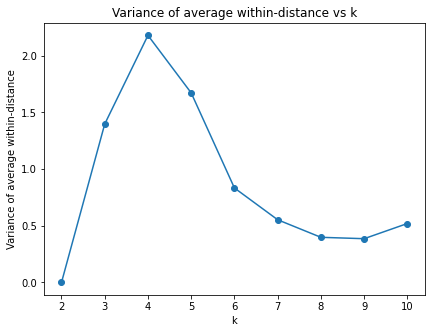

In [54]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(np.array(range(2,11)),var_wc,'o-')
plt.xlabel("k")
plt.ylabel("Variance of average within-distance")
plt.title("Variance of average within-distance vs k")
plt.show

This plot inicates that when k=4, the within average distance is not consitent. Therefore, we requestion the choice of the optimal clustering for k=4. This plot would support the optimal number of clusters k = 2 deduced from the CH-scores. 

#### Variability of CH-score

Similarly, we compute the variance of the CH-score over the 100 clusterings (for each k).

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('CH score')
ax.set_xlabel('Random initialisation')
ax.set_title('Calinski-Harabasz score vs random initialisation')
ax.plot(np.array(range(100)),chs[0,:].T,label='k=2')
ax.plot(np.array(range(100)),chs[1,:].T,label='k=3')
ax.plot(np.array(range(100)),chs[2,:].T,label='k=4')
ax.plot(np.array(range(100)),chs[3,:].T,label='k=5')
ax.plot(np.array(range(100)),chs[4,:].T,label='k=6')
ax.plot(np.array(range(100)),chs[5,:].T,label='k=7')
ax.plot(np.array(range(100)),chs[6,:].T,label='k=8')
ax.plot(np.array(range(100)),chs[7,:].T,label='k=9')
ax.plot(np.array(range(100)),chs[8,:].T,label='k=10')
ax.legend()

fig.tight_layout()

plt.show()

In [52]:
var_ch = np.var(chs,axis=1)
var_ch

array([5.04870979e-29, 4.20085948e+00, 4.44607767e+00, 2.35770088e+00,
       1.04089805e+00, 4.64802867e-01, 5.31449217e-01, 3.37506716e-01,
       3.04867124e-01])

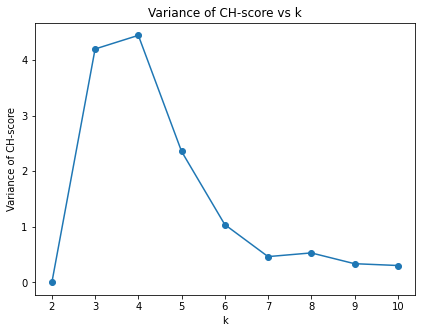

In [53]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(np.array(range(2,11)),var_ch,'o-')
plt.xlabel("k")
plt.ylabel("Variance of CH-score")
plt.title("Variance of CH-score vs k")
plt.show()

Again, this plot confirms our choice of clustering with k = 2. 

We have a few methods to choose from for measuring the quality of a clustering. If the ground truth is unavailable, we can use intrinsic methods, which evaluate the goodness of a clustering by considering how well the clusters are separated and how compact the clusters are. While many intrinsic methods return a similarity metric between objects in the data set, we will look at a way of measuring the similarities between all clusters while
ignoring permutations with the ARI score (which we describe and use in the last section of the coursework as well):


We use the expected similarity of all pair-wise comparisons between clusterings generated from a random initialisation. 

There are a number of different ways to measure the diversity of ensemble members including Adjusted Rand Index, which is based on label matching between two partitions, where two partitions are to be diverse if the labels of one partition do not match well with the labels of the other (ignoring the permutations, ie. if two clusterings are identical but have permuted labels then their ARI score will still be equal to 1). 

Indeed, the ARI score uses the contigency table summarising the overlap between two clusterings X and Y:  each entry $n_{ij}$ denotes the number of objects in common between clusters $X_{i}$ and $Y_j$ : $n_{ij}=|X_i \cap Y_j|$. From this table, the ARI score is defined by:
$$
ARI = \frac{\underset{i,j}{\sum} {n_{ij} \choose 2} - \frac{1}{{n \choose 2}} \left[ \underset{i}{\sum} {a_{i} \choose 2} \underset{j}{\sum} {b_{j} \choose 2} \right] }{ \frac{1}{2} \left[ \underset{i}{\sum} {a_{i} \choose 2} + \underset{j}{\sum} {b_{j} \choose 2} \right] - \frac{1}{{n \choose 2}} \left[ \underset{i}{\sum} {a_{i} \choose 2} \underset{j}{\sum} {b_{j} \choose 2} \right] }
$$
where $n_{ij}$ are values from the contingency table and $a_{i}$, $b_{j}$ are the sum of rows and columns of the contigency matrix respectively.

The function bellow codes this score, using the scipy.special.binom to compute the binomial coefficients. 

In [55]:
def ARI(label_1,label_2):
    #create contingency table
    values_1=np.unique(label_1)
    values_2=np.unique(label_2)
    n_1=len(values_1)
    n_2=len(values_2)
    n=len(label_1)
    table=np.zeros((n_1,n_2))
    for i in range(n_1):
        for j in range(n_2):
            table[i,j] = sum(1 for k in range(n) if (label_1[k]==i)&(label_2[k]==j))
    a=np.sum(table,axis=1)
    b=np.sum(table,axis=0)
    
    sum_ai_2=np.sum(scipy.special.binom(a,2))
    sum_bj_2=np.sum(scipy.special.binom(b,2))
    sum_nij_2=np.sum(scipy.special.binom(table,2))
    n_2=scipy.special.binom(n,2)
    
    ari=(sum_nij_2 - (sum_ai_2*sum_bj_2/n_2))/((sum_ai_2+sum_bj_2)/2 - (sum_ai_2*sum_bj_2)/n_2)
    return ari

For each k = 2, ..., 10, let's take the mean of the ARI score over all the pairwise ARI scores. Each pairwise ARI score is close to 0 for random clusters and close to 1 for very similar clusters. 

In [59]:
import scipy
def variability_clustering(X):
    chs,labels,optimal_labels = ch_all(X)
    ARI_score = np.zeros((9,100))
    for k in range(2,11):
        for j in range(100):
            label_1 = labels[(k-2)*100+j]
            ari=0
            for i in range(100):
                label_2 = labels[(k-2)*100+i]
                ari += ARI(label_1,label_2) / 10000

            ARI_score[k-2,j] = ari
    return ARI_score

In [60]:
ari_score=variability_clustering(X)
average_ari = np.sum(ari_score,axis=1)

Text(0.5, 1.0, 'Mean of ARI score vs k')

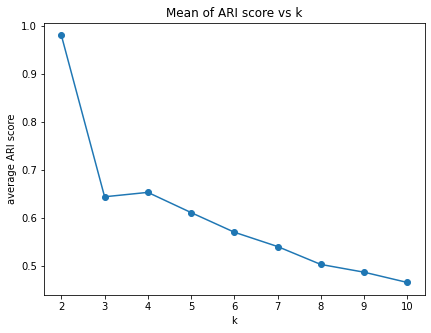

In [61]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(np.array(range(2,11)),average_ari,'o-')
plt.xlabel("k")
plt.ylabel("average ARI score")
plt.title("Mean of ARI score vs k")

From the plot, the consistency is maximal for k=2. Indeed, the average similarity measure is close to 1. This result makes sense because, the probabilities af having more similar clusters are higher when k is smaller. 


Therefore all three methods used to evaluate the variability and consistency of the plots, imply that the kmeans clusterings are more robust for k = 2. 

Therefore, we use the optimal K-means clustering (obtained from the maximal CH-score). Putting it back in context of the problem, it only detects the two groups and not the group of people who gave up karate. 

### 2.2 Dimensionality reduction of the feature matrix

#### 2.2.1

Let's introduce the dimensionality reduction because out feautre matrix F has too large dimensionality (100 features) against only 34 samples. The aim is to get rid of the redundant and noisy features, because we want to facilitate the clustering task which could struggle to deal with high dimensional data sets. 

The idea is to approximate each data point $\boldsymbol x^{(i)}$ according to an orthonormal basis $\phi_j$, j=1,...,m, (with  m < 100) as follow:
$$
\boldsymbol x^{(i)} = \sum_{j=1}^{100} a_j^{(i)} \boldsymbol\phi_j = \sum_{j=1}^{m} a_j^{(i)} \boldsymbol\phi_j  + \sum_{j=m+1}^{100} b_j \boldsymbol\phi_j 
$$
where $\boldsymbol\phi_j \in \mathbb{R}^{100}$. 
From this approximation, (under dimensionality reduction to m) we have the following mean squared error:
$$
MSE = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=m+1}^{100} ( a_j^{(i)} - b_j)^2
$$
with N=34.
The minimal MSE is atteined at the optimal $$b_j^{*} = \frac{1}{N} \sum_{i=1}^{N} a_j^{(i)}$$.

As seen in lectures, when plugging the optimal solution back in the MSE formula, we get:
$$
MSE = \sum_{j=m+1}^{100} \boldsymbol\phi_j^T C_x \boldsymbol\phi_j
$$

Now, to find the optimal orthonormal $\phi_j$, we carry a Langrangian optimisation with constrain $b_j = b_j^{*}$ (cf.lecture notes) and we obtain the following solution:
$$
C_x \boldsymbol\phi_j^{*} = \lambda_j \boldsymbol\phi_j^{*}
$$

where $\lambda_j$ and $\boldsymbol\phi_j^{*}$, are simply the eigenvalues and eigenvectors of the convariance matrix $C_x$ of the data set. 

The MSE becomes $MSE = \sum_{j=m+1}^{p} \lambda_j$ and to choose the optimal number of dimension m, we can use the "elbow method" when plotting the eigenvalues. 

In [62]:
from scipy.sparse import linalg

def pca_function(X,k):

  # create covariance matrix S
  C = 1.0/(len(X)-1) * np.dot(X.T, X)


  # compute eigenvalues and eigenvectors using the eigsh scipy function
  eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

  # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
  sorted_index = np.argsort(eigenvalues)[::-1]
  eigenvalues=eigenvalues[sorted_index]
  eigenvectors=eigenvectors[:,sorted_index ]

  # transform our data
  X_pca = X.dot(eigenvectors)

  return X_pca, eigenvectors, eigenvalues

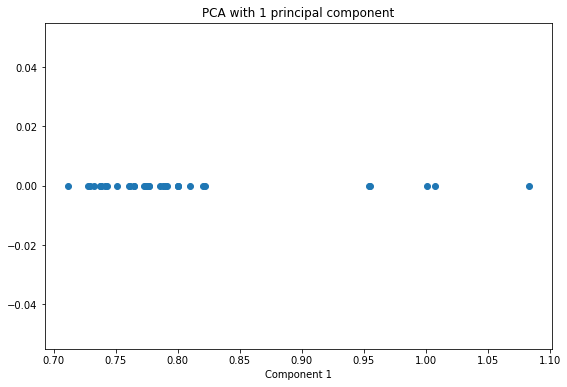

In [67]:
# choose our number of principle components
d=1
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,d) 

fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
plt.scatter(X_pca[:,0],np.zeros(X.shape[0]),marker='o')
plt.xlabel('Component 1')
plt.title('PCA with 1 principal component')
plt.show()


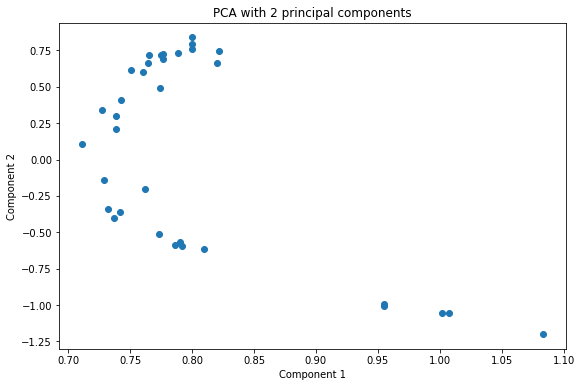

In [68]:
# choose our number of principle components
d=2
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,d) 

fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA with 2 principal components')
plt.show()

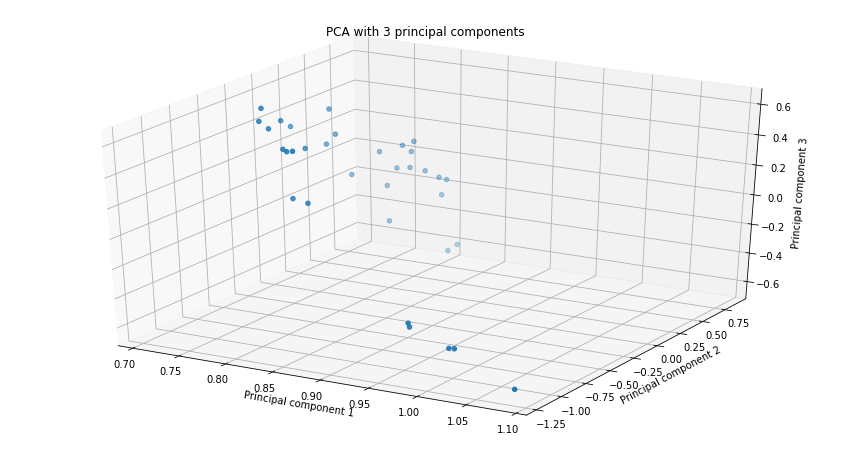

In [69]:
# choose our number of principle components
d=3
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,d) 

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2])

ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')

ax.set_title('PCA with 3 principal components')

plt.show()

All three plots seem to indicate several things:
- the data is linear: we do not need to use higher dimensional data
- the apropriate number of clusters is 3: we can clearly see this in all 3 plots. 

These 3 clusters seem to correspond to the 2 subgroups of karate members that were split into 2 clubs and the subgroup of inidividuals who have up karate (looks like this is the case of 5 individuals). 

However, we do not know which reduced dimension d best fits the data. To verify this, we will analyse the eigenvalues which play a major role in the MSE. 

#### 2.2.2

As seen in the lecture notes, the ideal number of eigenvalus is located when the explained variance drops drastically. Let's first plot the frist 10 eigenvalues. 

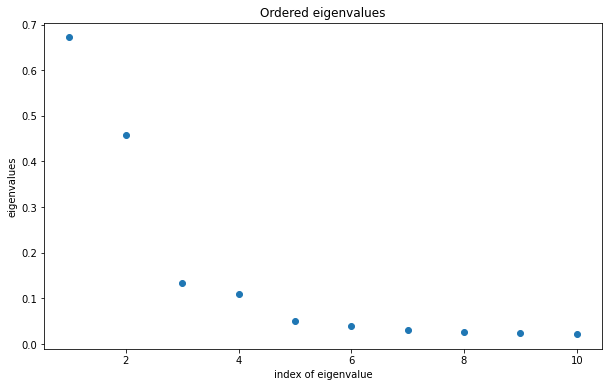

In [71]:
X_pca, eigenvectors, evalues = pca_function(X,10) 

plt.figure(figsize = (10,6))
plt.scatter(np.array(range(1,11)),evalues)
plt.xlabel("index of eigenvalue")
plt.ylabel("eigenvalues")
plt.title("Ordered eigenvalues")
plt.show()

Now, PCA replaces original variables with new variables, called principal components, which are orthogonal and have variances in decreasing order. Now, since the principal components are orthogonal, they have zero covariations and the covariance matrix is a diagonal matrix with its have variances in decreasing order. This implies that the variances are the eigenvalues of the covariance matrix, which are also in decreasing order.
Therefore, the explained variances are the diagonal of the covariance matrix corresponding to the eigenvalues for each principal component over the sum of the eigenvalues.
The first d eigenvalues of a PCA for d and k > d are the same but their explained variances will differ. 

In [72]:
d=2
X_pca, eigenvectors, eigenvalues = pca_function(X,d) 

k=4
X_pca2, eigenvectors2, eigenvalues2 = pca_function(X,k)

print('Eigenvalues of covariance for d=2 are: {}'.format(eigenvalues))
print('Eigenvalues of covariance for d=4 are: {}'.format(eigenvalues2))
print('Explained covariances for d=2 are: {}'.format(eigenvalues/np.sum(eigenvalues)))
print('Explained covariances for d=4 are: {}'.format(eigenvalues2/np.sum(eigenvalues2)))

Eigenvalues of covariance for d=2 are: [0.67162218 0.45752436]
Eigenvalues of covariance for d=4 are: [0.67162218 0.45752436 0.13320938 0.11023311]
Explained covariances for d=2 are: [0.59480515 0.40519485]
Explained covariances for d=4 are: [0.48931047 0.33332946 0.09704972 0.08031035]


In [73]:
def explained_variance2(X):
    fig = plt.figure(figsize=(15, 5))
    exp_var=np.zeros(10)
    d=10
    X_pca, eigenvectors, eigenvalues = pca_function(X,d) 
    explained_variances = (eigenvalues / eigenvalues.sum())  
    print('The proportion of explained variance for the first d principle components is: {}'.format(explained_variances))
    plt.plot(np.array(range(1,11)),explained_variances,'o-')
    plt.xlabel("k")
    plt.ylabel("explained_variance")
    plt.title("Proportion of explained variance for the first d principle components")

    plt.show()
    return eigenvalues

The proportion of explained variance for the first d principle components is: [0.42878921 0.29210099 0.08504595 0.07037702 0.03180333 0.0253507
 0.01970146 0.01716211 0.01565989 0.01400935]


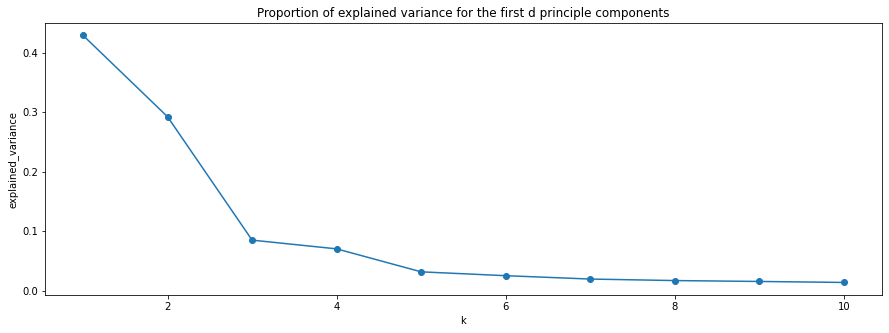

In [74]:
evalues = explained_variance2(X)

From this graph, we can see that the elbow is located at d=2 and therefore, we set d=2 to be the most optimal reduced dimension. 



Mathematically speaking, the PCA uses the eigen-decomposition of $F^{T}F$ and this plot indicates that $F^{T}F$ has 2 significantly larger eigenvalues. Therefore the 2 components we will choose to reduce dimensions are the 2 eigenvectors associated with these 2 large eigenvalues. 

Refering back to the 3 plots in 2.2.1, we have plotted the data according to their projections into the eigenvectors $\boldsymbol \phi_j$. 

Putting it back in context with the origin of our data, this would mean that approximately 98 features are redundant or noisy and do not bring significant information about the split of the karate club. 

### 2.3 Graph-based analysis

Let's now introduce some Graph-based analysis used for the same purpose of clustering the 34 members from the karate club. 
Let's set the adjacent matrix A $\in \mathbb{R}^{34 \mathrm{x} 34}$ in which each element $A_{ij} = 1$ corresponds to a friendship betwen $i^{th}$ and $j^{th}$ members and the number of edges E = 78. 

In graph-based theory, a graph can be defined by:
- its nodes: here corresponding to an individual
- its edges, ie. the pairwise interactions between each nodes : here the frienships are unweighted (each frienship is as important) and undirected (frienship is both ways).


In [75]:
A=graph
E=78
graph.shape

(34, 34)

The domain of graph-theroy is very wide: diffusion on graphs, random walks, clustering on graphs. 

Here, we will study the application of graph partitioning. 

#### 2.3.1 Centralities

Let's first introduce the concept of centrality of a node. 

Each node is assigned a value of centrality which indicated its importance. They can be compared with the others' values and ranked from most central to least central

This notion of importance can be viewed from different perspectives, using different methods to assign the centrality values.

**PageRank centrality** 

PageRank centrality is the stationary solution of a PageRank iterative algorithm with equation:
$$
\boldsymbol c_{PR_{t+1}} = \alpha (AD^{-1}) \boldsymbol c_{PR_{t}} + (1-\alpha) \frac{1}{N}, \quad \quad \quad \alpha \in [0,1]
$$
This is the equation of a random walk process with transition matrix $AD^{-1}$ with probability $\alpha$ and transitions to any node in the graph with probability $(1-\alpha)$. The parameter $\alpha$ garantees the ergodicity of the random walk and is set to 0.85 here. 

The stationary solution of this problem is the solution to:
$$
\boldsymbol c_{PR} \left( I - \alpha (AD^{-1}) \right)= (1-\alpha) \frac{\boldsymbol1}{N}
$$
The function bellow solves this problem using the scipy library to solve the matrix-vector eqaution. 

In [76]:
def pagerank_centrality(A,alpha):
    N=A.shape[0]
    D_inv=np.diag(np.reciprocal(np.sum(A,axis=1)).T)
    AD_inv=A@D_inv
    c_pr = np.linalg.solve(np.eye(N)-alpha*AD_inv,(1-alpha)/N*np.ones(N))
    rank = np.argsort(c_pr)
    rank=np.flip(rank)
    rank_pr=np.zeros(34)
    for i in range(34):
        rank_pr[rank[i]] = i
    return c_pr,rank,rank_pr

To get an idea of the centrality results obtaines, we can 

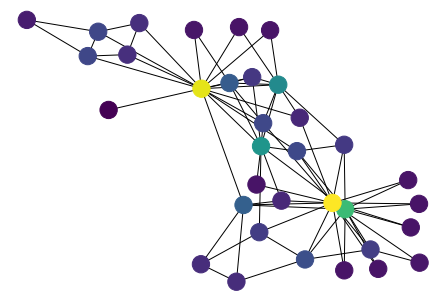

In [81]:
import networkx as nx
G = nx.Graph(A)
c_pr, rank_pr, rank_pr2 = pagerank_centrality(A,0.85)
nx.draw(G,node_color=c_pr)

In [82]:
rank_pr

array([33,  0, 32,  2,  1, 31,  3, 23,  8, 13,  6,  5, 29, 27, 30,  7, 10,
        4, 24, 25, 19, 28, 16, 26, 12, 21, 17, 14, 18, 20, 22, 15,  9, 11])

The graph shows the most central nodes in yellow (the main two central nodes are 33 and 0 according to the PageRank centrality).

**Degree centrality**

From, the lecture notes and other papers, we recall two different notation for the degree centrality of a node which are proportional:
$$
c_{d}(i) = \frac{d_i}{2\mathrm{E}} \quad \propto \quad \frac{d_i}{\mathrm{N} -1}
$$
where $d_i$ is the number of undirected edges associated to node i, E is the number of edges in the graph and N is the number of vertices in the graph.
In matrix-vector form, it give:
$$
\frac{A \boldsymbol 1}{2\mathrm{E}}
$$ where A is the adjacent matrix. 
Let's show that comparing the degrees with the two formulas are clearly equivalent by showing that the results are proportional.
Obviously their order are equivalent, just a different 'normalisation'.

In [83]:
def degree_centrality(A,E):
    c_d=1/(2*E)*np.sum(A,axis=1)
    rank = np.argsort(c_d)
    rank = np.flip(rank)
    rank_d=np.zeros(34)
    for i in range(34):
        rank_d[rank[i]] = i
    return c_d,rank,rank_d

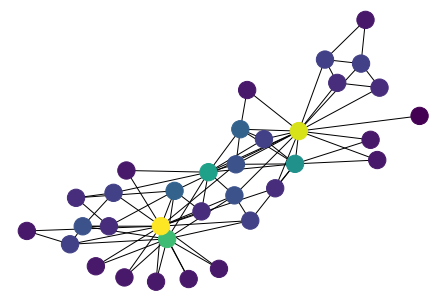

In [84]:
c_d,rank_d,rank_d2 = degree_centrality(A,E)
nx.draw(G,node_color=c_d)

In [85]:
rank_d

array([33,  0, 32,  2,  1, 31,  3, 23, 13,  8, 27,  5,  6, 29, 30,  7, 25,
       24, 28, 10,  4, 19,  9, 15, 12, 14, 17, 18, 20, 21, 22, 26, 16, 11])

Again, the degree centrality shows that 33 and 0 are the two main central nodes. While the centralities seem to be different from the configuration of the graph, we see that the rankings are very similar. 

**Eigenvector centrality**

The eigenvalue centrality of node i depends the eigenvalues centralities of its neighbouring nodes. It can be written as:
$$
c_e(i) = \alpha \sum_{j} [A_{ij} \boldsymbol c _{e}(j)]\\
$$
This indeed, only depends on the centralities of the connected nodes since, when $i^{th}$ and $j^{th}$ nodes are not connected the $A_{ij} = 0$. 
In matrix-vector form, we have:
$$
\boldsymbol c_e = \alpha A \boldsymbol c_e 
$$
This expression can be reformulated as an eigenvalue/vector problem:
$$
\lambda \boldsymbol c_e = A \boldsymbol c_e 
$$
where $\lambda$ is an eigenvector of A and $\boldsymbol c_e$ is an eigenvector of A (ie. eigenvector associated with largest eigenvalue). 
It can be shown that this is solved by the leading eigenvector of A. Hence the
eigenvector centrality of each node is given by the component of the leading
eigenvector of the adjacency matrix.

In [86]:
def eigenvector_centrality(A,E):
    eigenvalues,eigenvectors= linalg.eigsh(A, 1,which = 'LM', return_eigenvectors=True) 
    c_e = np.squeeze(np.abs(eigenvectors))
    rank = np.argsort(c_e)
    rank=np.flip(rank)
    rank_e = np.zeros(34)
    for i in range(34):
        rank_e[rank[i]] = i
    return c_e, rank, rank_e

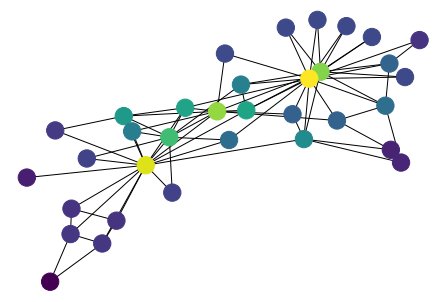

In [87]:
c_e,rank_e, rank_e2 = eigenvector_centrality(A,E)
nx.draw(G,node_color=c_e)

In [88]:
rank_e

array([33,  0,  2, 32,  1,  8, 13,  3, 31, 30,  7, 23, 19, 29, 27, 28,  9,
       15, 18, 14, 20, 22, 17, 21, 12,  5,  6, 10,  4, 26, 25, 24, 11, 16])

From this graph, we see that there are not two main central nodes that step out but more a group of central points. The ranking also appear to have slightly change compared to the other two centrality measures. 

This is an interesting observation that we will try to explain and confirm with correlation plots. Let's first concatenate all 3 centrality vectors and 3 ranking vectors. 

In [92]:
d_rank_all = np.zeros((34,6))
d_rank_all[:,0] = c_pr
d_rank_all[:,1] = c_d
d_rank_all[:,2] = c_e 
d_rank_all[:,3] = rank_pr2
d_rank_all[:,4] = rank_d2 
d_rank_all[:,5] = rank_e2

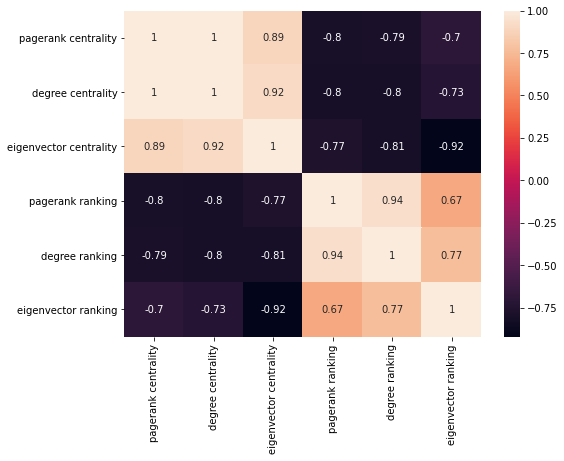

In [93]:
import seaborn as sns

df = pd.DataFrame(d_rank_all,columns= ['pagerank centrality','degree centrality','eigenvector centrality','pagerank ranking','degree ranking', 'eigenvector ranking'])
correlation_mat = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_mat, annot = True)
plt.show()

We can conclude several things from this correlation matrix:
- The centralities and rankings of all nodes are negatively correlated: this makes sense since the higher the centrality the lower the ranking (ie. 0 for the lowest ranking). 
- The degree centralities and PageRank centralities are perfectly correlated, ie. their correlation is equal to 1 which means that they are propostional. 
- All other vectors of centralities and ranking have high correlation (either positive in between centralities  and in between rankings or negative between centralities and ranking). 

Let's plot the scatter plot of the centralities against each centrality to understand their correlation better

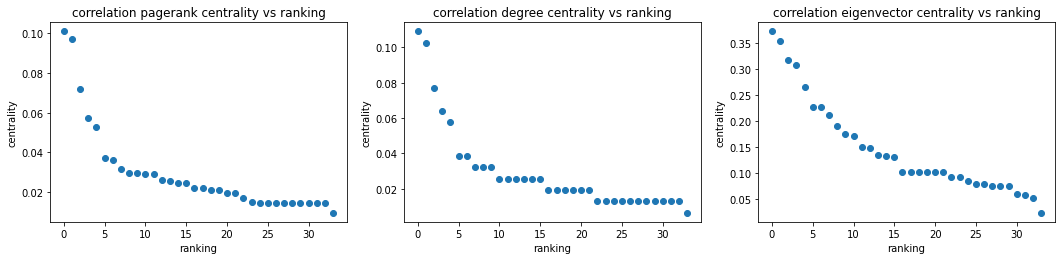

In [90]:
d_rank_all = np.zeros((34,6))
d_rank_all[:,0] = c_pr
d_rank_all[:,1] = rank_pr2
d_rank_all[:,2] = c_d
d_rank_all[:,3] = rank_d2
d_rank_all[:,4] = c_e
d_rank_all[:,5] = rank_e2


fig = plt.figure(figsize = (15,10))

plt.subplot(3, 3, 1)
plt.scatter(d_rank_all[:,1],d_rank_all[:,0])
plt.xlabel("ranking")
plt.ylabel("centrality")
plt.title("correlation pagerank centrality vs ranking")

plt.subplot(3, 3, 2)
plt.scatter(d_rank_all[:,3],d_rank_all[:,2])
plt.xlabel("ranking")
plt.ylabel("centrality")
plt.title("correlation degree centrality vs ranking")

plt.subplot(3, 3, 3)
plt.scatter(d_rank_all[:,5],d_rank_all[:,4])
plt.xlabel("ranking")
plt.ylabel("centrality")
plt.title("correlation eigenvector centrality vs ranking")

plt.tight_layout()
plt.show()

The correlation degree is as expected a discrete function and the pagerank and eigenvector centralities seem to be more continuous. The difference between the eigenvector centralities and the other two centralities is that the values of the seem to be uniformly distributed between 0 and 0.4, whereas the other two have values that tend to lowe values. 

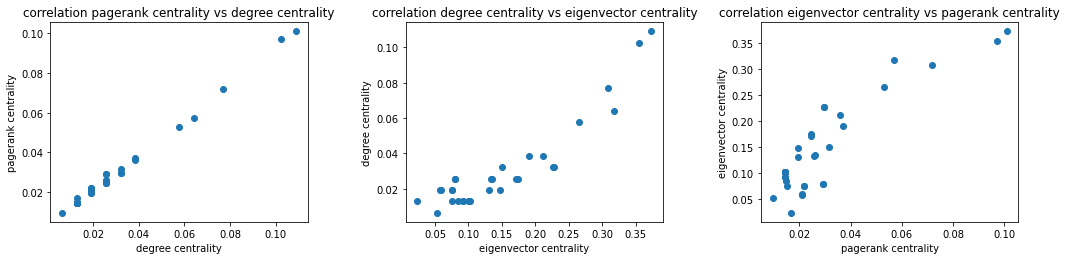

In [96]:
d_rank_all = np.zeros((34,6))
d_rank_all[:,0] = c_pr
d_rank_all[:,1] = rank_pr2
d_rank_all[:,2] = c_d
d_rank_all[:,3] = rank_d2
d_rank_all[:,4] = c_e
d_rank_all[:,5] = rank_e2

fig = plt.figure(figsize = (15,10))

plt.subplot(3, 3, 1)
plt.scatter(d_rank_all[:,2],d_rank_all[:,0])
plt.xlabel("degree centrality")
plt.ylabel("pagerank centrality")
plt.title("correlation pagerank centrality vs degree centrality")

plt.subplot(3, 3, 2)
plt.scatter(d_rank_all[:,4],d_rank_all[:,2])
plt.xlabel("eigenvector centrality")
plt.ylabel("degree centrality")
plt.title("correlation degree centrality vs eigenvector centrality")

plt.subplot(3, 3, 3)
plt.scatter(d_rank_all[:,0],d_rank_all[:,4])
plt.xlabel("pagerank centrality")
plt.ylabel("eigenvector centrality")
plt.title("correlation eigenvector centrality vs pagerank centrality")

plt.tight_layout()
plt.show()

This plot clearly shows that the page centrality values and degree centrality values are proportional for the 34 nodes. Actually, they seem to be identical. 

The other two graphs show the tendency of a high correlation but it is not as perfect. This can be explained by the fact that eigenvector centralities are uniformly distributed whereas the other two seem to be normally ditributed. 

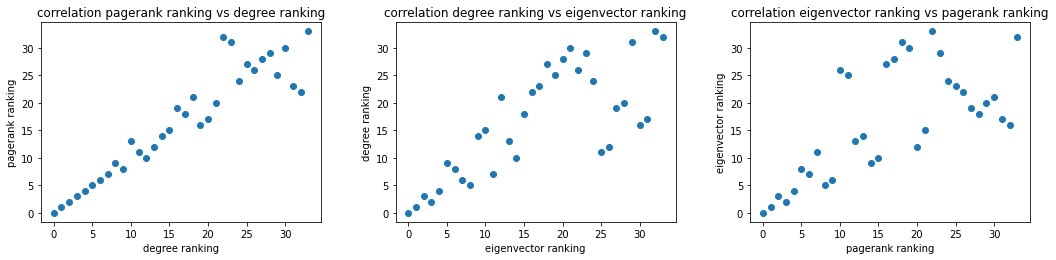

In [97]:
d_rank_all = np.zeros((34,6))
d_rank_all[:,0] = c_pr
d_rank_all[:,1] = rank_pr2
d_rank_all[:,2] = c_d
d_rank_all[:,3] = rank_d2
d_rank_all[:,4] = c_e
d_rank_all[:,5] = rank_e2

fig = plt.figure(figsize = (15,10))

plt.subplot(3, 3, 1)
plt.scatter(d_rank_all[:,3],d_rank_all[:,1])
plt.xlabel("degree ranking")
plt.ylabel("pagerank ranking")
plt.title("correlation pagerank ranking vs degree ranking")

plt.subplot(3, 3, 2)
plt.scatter(d_rank_all[:,5],d_rank_all[:,3])
plt.xlabel("eigenvector ranking")
plt.ylabel("degree ranking")
plt.title("correlation degree ranking vs eigenvector ranking")

plt.subplot(3, 3, 3)
plt.scatter(d_rank_all[:,1],d_rank_all[:,5])
plt.xlabel("pagerank ranking")
plt.ylabel("eigenvector ranking")
plt.title("correlation eigenvector ranking vs pagerank ranking")

plt.tight_layout()
plt.show()

The interesting remark from these plots is that the ranking of the fist 8 most central nodes according to pagerank and degree centrality, are identically ranked. 

Summing up all the correlations, we can see that the 

#### 2.3.1 Community detection

In this section, we will split the data in communities in graph using Clauset-Newman-Moore greedy modularity maximization. According to the networkx ressources, this method supports the Graph class and does not consider edge weights, as required.

Before explaining how the algorithm works, we will introduce some notions of modularity. Firstly, the modularity method is based on combinatorial notions (somehow related to dynamical aspects). It tries to include a labelling of the nodes of a graph by the criteria of modularity, which acts like a cost function as follow:
$$
Q = \frac{1}{2E} \left[ H^{T} \left[ A- \frac{1}{2E} d d^{T}\right] H \right] 
$$
where H is the membership matrices summarising the communities and $Z= A- \frac{1}{2E} d d^{T}$ is the Modularity matrix.

Now, the aim is to maximise the cost function Q over all membership martices H and find the optimal Q which :
- maximising the number of edges within communities 
- minimising the number of edge between communities
This approach is very similar to the kmeans algorithm

To detect the communities, the algorithm iteratively implements 2 phases:
- phase 1: compute the local modularity by adding each vertex to its neighbour with the highest modularity gain (evaluated with gradient) 
- phase 2: merge nodes from local communities into 1 node per community 

The algorithm stops when no improvement in maximal modularity appears. 

In [98]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
G = nx.Graph(A)
communities = greedy_modularity_communities(G)
c = list(communities)
print('The optimal number of communities is:',len(c))
print('Elements of first community:', c[0])
print('Elements of second community:', c[1])
print('Elements of third community:', c[2])

The optimal number of communities is: 3
Elements of first community: frozenset({32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31})
Elements of second community: frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21})
Elements of third community: frozenset({0, 4, 5, 6, 10, 11, 16, 19})


In [143]:
# find the nodes forming the communities
node_communities = []

for i in communities:
    node_communities.append(list(i))

node_communities

node_community_id = np.zeros(34)
node_community_id[node_communities[1]]=1
node_community_id[node_communities[2]]=2

print('The resulting communities labels are:')
print(node_community_id)

The resulting communities labels are:
[2. 1. 1. 1. 2. 2. 2. 1. 0. 1. 2. 2. 1. 1. 0. 0. 2. 1. 0. 2. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Let's now plot the graph according to the 3 communites and their respective nodes. 

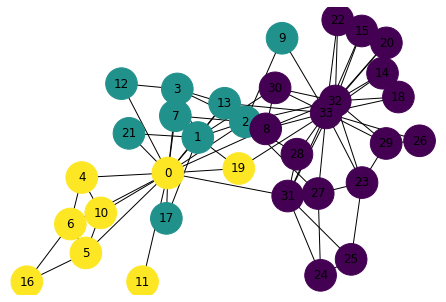

In [101]:
# drawing networkx graph
pos=nx.spring_layout(G)
nx.draw(G,pos=pos,node_size=1000,with_labels=True,node_color=node_community_id)

**Distribution across the 3 communities**

Let's now show the distribution of the top 8 most central nodes according to degree centrality and pagerank centrality. We have seen in the previous section that the top 8 central nodes are the same for both centrality measures. 

In [144]:
print('Top 8 most central nodes ordered according to degree centrality')
rank_d[:8]

Top 8 most central nodes ordered according to degree centrality


array([33,  0, 32,  2,  1, 31,  3, 23])

In [145]:
print('Top 8 most central nodes ordered according to PageRank centrality')
rank_pr[:8]

Top 8 most central nodes ordered according to PageRank centrality


array([33,  0, 32,  2,  1, 31,  3, 23])

Let's see now the how nodes are distributed accross the 3 communities.

In [107]:
print('The node communities contain the following node:')
print('Community 1', node_communities[0])
print('Community 2', node_communities[1])
print('Community 3', node_communities[2])

The node communities contain the following node:
Community 1 [32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Community 2 [1, 2, 3, 7, 9, 12, 13, 17, 21]
Community 3 [0, 4, 5, 6, 10, 11, 16, 19]


We plot the required histogram bellow. 

In [108]:
def count(node_communities, rank):
    count_0=0
    count_1=0
    count_2=0
    for i in rank:
        if i in node_communities[0]:
            count_0 += 1
        elif i in node_communities[1]:
            count_1+=1
        else:
            count_2+=1
    return np.array([count_0,count_1,count_2])

In [109]:
print('The communities count for Pagerank top 8 central nodes is',count(node_communities,rank_pr[:8]))
print('The communities count for degree top 8 central nodes is',count(node_communities,rank_d[:8]))

The communities count for Pagerank top 8 central nodes is [4 3 1]
The communities count for degree top 8 central nodes is [4 3 1]


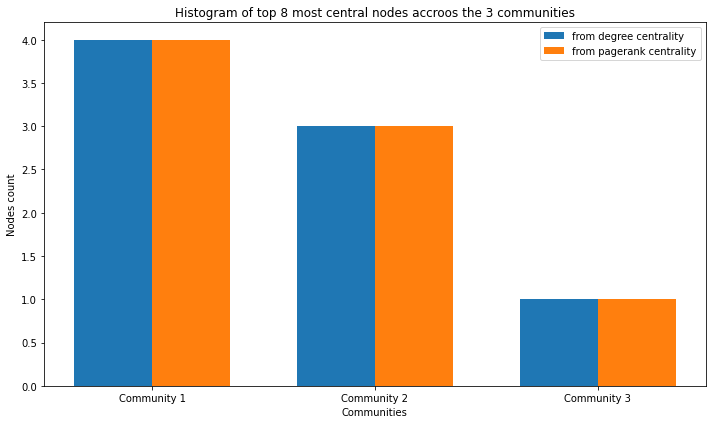

In [110]:
labels = ['Community 1', 'Community 2', 'Community 3']
count_d = count(node_communities,rank_d[:8])
count_pr = count(node_communities,rank_pr[:8])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, count_d, width, label='from degree centrality')
rects2 = ax.bar(x + width/2, count_pr, width, label='from pagerank centrality')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nodes count')
ax.set_xlabel('Communities')
ax.set_title('Histogram of top 8 most central nodes accroos the 3 communities')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

As we have seen in the previous section, the distributions are the same. 

To link these graphs to the original problem of the karate club split, we can say that the 8 individual with the most friendships will be distributed as above into the 3 communities:
- 4 will go in community one: probably a subgroup of the splitted karate club
- 3 will go in community two: probably the other subgroup of the splitted karate club
- 1 will go in community three: this individual probabily corresponds to the individuals giving up karate


#### 2.3.1 Comparing clusterings

Recall the optimal clusterings from the first section of task 2 (k-means) and the third section (Graph-based analysis). 

In [116]:
print('The kmeans global optimal clustring is')
print(labels_km)

The kmeans global optimal clustring is
[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.]


In [117]:
labels_g = node_community_id
print('The graph clustering is')
print(labels_g)

The graph clustering is
[2. 1. 1. 1. 2. 2. 2. 1. 0. 1. 2. 2. 1. 1. 0. 0. 2. 1. 0. 2. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [126]:
true_labels = ground_truth
true_labels = np.where(true_labels == 'Mr. Hi', 0., true_labels)
true_labels = np.where(true_labels == 'Officer', 1., true_labels)
print('The true clustering is')
print(true_labels.T)

The true clustering is
[[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0
  1.0 0.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]]


We will now evaluate the quality of the clusterings obtaines using an extrinsic method. Indeed, when the ground truth is available, we can compare it with a clustering using different types of score Q.

In general, a measure Q on clustering quality is effective if it satisfies the following four essential criteria:
- Cluster homogeneity. This requires that the more pure the clusters in a clustering are, the better the clustering. We can refer here to the robustness measured in 2.1.3
- Cluster completeness. This is the counterpart of cluster homogeneity. Cluster completeness requires that for a clustering, if any two objects belong to the same category according to ground truth, then they should be assigned to the same cluster.
- Rag bag. There is often a “rag bag” cluster containing data points that cannot be merged with other data points. The rag bag criterion states that putting a heterogeneous object into a pure cluster should be penalized more than putting it into a rag bag. 
- Small cluster preservation. If a small category is split into small pieces in a clustering, those small pieces may likely become noise and thus the small category cannot be discovered from the clustering. The small cluster preservation criterion states that splitting a small category into pieces is more harmful than splitting a large category into pieces. 

After some research, we have found that indeed the Adjusted Rand Index (ARI) satisfies all four criterias. 

Recall the the ARI score is defined by:
$$
ARI = \frac{\underset{i,j}{\sum} {n_{ij} \choose 2} - \frac{1}{{n \choose 2}} \left[ \underset{i}{\sum} {a_{i} \choose 2} \underset{j}{\sum} {b_{j} \choose 2} \right] }{ \frac{1}{2} \left[ \underset{i}{\sum} {a_{i} \choose 2} + \underset{j}{\sum} {b_{j} \choose 2} \right] - \frac{1}{{n \choose 2}} \left[ \underset{i}{\sum} {a_{i} \choose 2} \underset{j}{\sum} {b_{j} \choose 2} \right] }
$$
where $n_{ij}$ are values from the contingency table and $a_{i}$, $b_{j}$ are the sum of rows and columns of the contigency matrix respectively.

In [131]:
def ARI(label_1,label_2):
    #create contingency table
    values_1=np.unique(label_1)
    values_2=np.unique(label_2)
    n_1=len(values_1)
    n_2=len(values_2)
    n=len(label_1)
    table=np.zeros((n_1,n_2))
    for i in range(n_1):
        for j in range(n_2):
            table[i,j] = sum(1 for k in range(n) if (label_1[k]==i)&(label_2[k]==j))
    a=np.sum(table,axis=1)
    b=np.sum(table,axis=0)
    
    sum_ai_2=np.sum(scipy.special.binom(a,2))
    sum_bj_2=np.sum(scipy.special.binom(b,2))
    sum_nij_2=np.sum(scipy.special.binom(table,2))
    n_2=scipy.special.binom(n,2)
    
    ari=(sum_nij_2 - (sum_ai_2*sum_bj_2/n_2))/((sum_ai_2+sum_bj_2)/2 - (sum_ai_2*sum_bj_2)/n_2)
    return ari,table

Let's now compute the ARI score to measure the similarities between the kmeans optimal cluster, the graph-based communities and the ground truth groups. The adjusted Rand index has value 0 when the two clusterings are completely random and 1 when the clusterings are identical (up to permutation).

It can also happend that the ARI has negative values. 

In [141]:
ari_t_km,table_t_km = ARI(true_labels,labels_km)
print('The ARI score between the true labels and the kmeans labels is:',ari_t_km)
print('with contigency matrix:')
df_t_km=pd.DataFrame(table_t_km)
df_t_km

The ARI score between the true labels and the kmeans labels is: 0.0012970168612192327
with contigency matrix:


,0,1
0,8.0,9.0
1,11.0,6.0


**Interpretation**

When comparing the kmeans clustering and the true labels, we see that their ARI score is very close to zero. Indeed, from the contigency matrix we see that there is no tendency of true classification. All the entry have frquencies which are close to each other. This means for example that if the kmeans returns label 1 for individual i then the chances that its true label is 1 is 6/15 and that its true label is 0 is 9/15. Similarly all entries seem to indicate that both clusterings are independent, or at least that their results are very different.

Therefore, even if the number of clusters is 2 for both clusterings, we can see that this does not imply similarities. The reason for this is that the kmeans is based on feature data which is potential not relevant for predicting the acrimonious split. 

In [133]:
ari_t_g,table_t_g = ARI(true_labels,labels_g)
print('The ARI score between the true labels and the graph communities labels is:',ari_t_g)
print('with contigency matrix:')
df_t_g=pd.DataFrame(table_t_g)
df_t_g

The ARI score between the true labels and the graph communities labels is: 0.5684394071490846
with contigency matrix:


,0,1,2
0,1.0,8.0,8.0
1,16.0,1.0,0.0


**Interpretation** 

These results seem to indicate that there is a relatively high similarity between the graph-based communities and the true split. Indeed, the contigency matrix inicates that the true labels of 1 correspond to the community 1 and that the true labels of 0 are split between community 2 and 3. There are only 2 individuals who doesn't follow this tendency and therefore for clusterings of size 2 and 3 the obtained ARI score is very good. 

This could indicate that the acronimous split was based more on the friendship between the members that on the personality traits. In other terms, clustering based on personality similarities is not ideal to predict the split. 
This is an interesting conclusion, reflecting on the social behaviour of the members. If we take a philosophical approach to this situation, human relationships has a bigger impact on the member's choice than their personality traits. 

We cannot ignore that the feature marix has interesting information since the PCA has predicted 3 groups of memebers like the graph-based method. It would be interesting to compare these clusterings too. 

In [134]:
ari_km_g,table_km_g = ARI(labels_g,labels_km)
print('The ARI score between the kmeans labels and the graph communities labels is:',ari_km_g)
print('with contigency matrix:')
df_km_g=pd.DataFrame(table_km_g)
df_km_g

The ARI score between the kmeans labels and the graph communities labels is: -0.031487014479429976
with contigency matrix:


,0,1
0,10.0,7.0
1,5.0,4.0
2,4.0,4.0


**Interpretation**

Finally, when comparing the kmeans clustering and the graph-based communities, we see that the dissimilarities are relatively high. 
Indeed, negative ARI implies that the agreement is less than what is expected from a random result. This could means the results are complementary. In other words, the individuals within a community based on frienship have all sorts of personality traits. 




## Conclusion of task 2

To conclude on the clustering task, the type of data used to train the model will have a huge impact on the resulting clusters. Even if the individuals and the problem is the same, we see that the graph-based clustering based on frienship relations between members is more appropriate to predict the karate club split. However, the feature matrix with the personality traits can be used for many other problems with kmeans and PCA since the results are robust and consistent. 

# Conclusion 

In this coursework, we have covered a good amount of Data Science methods and algorithms. It was interesting to code the MLP model from scratch to have a better understanding of the over-fitting, the long runing-times and the non-linear data problems which we can solve with regularised CNN models. 
It was also interesting to see in task 2, different approaches to the same problem, each with different types of datas. This lead to some interesting results regarding the initial approach to the problem. 

## References



- Methods for Data Science Coding tasks, by Felix Laumann Imperial College London
- Methods for Data Science Lecture notes, by Mauricio, Imperial College London
- Cross-entropy loss function: https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy
- Softmax function https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
- Calinski-Harabasz https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/
- Derivative of cross-entropy of softmax function: https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
- Code neural network from scratch: https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
- Clustering quality: https://www.sciencedirect.com/topics/computer-science/clustering-quality 